In [1]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [2]:
# Libraries
import time
import ast
import copy
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data

In [3]:
# Load pre-processed data and display it
path_to_preprocessed_data = "/kaggle/input/small-data-preprocessed-thesis/small_data_preprocessed.csv"
data = pd.read_csv(path_to_preprocessed_data)
data

,label,text,gensim_remove,nltk_remove,gensim_token_keras,nltk_token_keras,gensim_token_nltk,nltk_token_nltk,nltk_gensim_token_keras,nltk_nltk_token_keras,nltk_gensim_token_nltk,nltk_nltk_token_nltk,nltk_stemmer_gensim_token_keras,nltk_stemmer_nltk_token_keras,nltk_stemmer_gensim_token_nltk,nltk_stemmer_nltk_token_nltk
0,Negative,not My kind of writing: I do not care for thi...,My kind writing I care author reading couple b...,kind writing care author reading couple books...,"['my', 'kind', 'writing', 'i', 'care', 'author...","['kind', 'writing', 'care', 'author', 'reading...","['My', 'kind', 'writing', 'I', 'care', 'author...","['kind', 'writing', 'care', 'author', 'reading...","['my', 'kind', 'write', 'i', 'care', 'author',...","['kind', 'write', 'care', 'author', 'reading',...","['My', 'kind', 'write', 'I', 'care', 'author',...","['kind', 'write', 'care', 'author', 'reading',...","['my', 'kind', 'write', 'i', 'care', 'author',...","['kind', 'write', 'care', 'author', 'read', 'c...","['my', 'kind', 'write', 'i', 'care', 'author',...","['kind', 'write', 'care', 'author', 'read', 'c..."
1,Negative,Just in case you didn't know what you were wa...,Just case didnt know watching The Beverly Hill...,case nt know watching Beverly Hillbillies C...,"['just', 'case', 'didnt', 'know', 'watching', ...","['case', 'nt', 'know', 'watching', 'beverly', ...","['Just', 'case', 'didnt', 'know', 'watching', ...","['case', 'nt', 'know', 'watching', 'Beverly', ...","['just', 'case', 'didnt', 'know', 'watch', 'th...","['case', 'nt', 'know', 'watch', 'beverly', 'hi...","['Just', 'case', 'didnt', 'know', 'watch', 'Th...","['case', 'nt', 'know', 'watch', 'Beverly', 'Hi...","['just', 'case', 'didnt', 'know', 'watch', 'th...","['case', 'nt', 'know', 'watch', 'beverli', 'hi...","['just', 'case', 'didnt', 'know', 'watch', 'th...","['case', 'nt', 'know', 'watch', 'beverli', 'hi..."
2,Negative,An unimpressive let down: I read Lord of the ...,An unimpressive let down I read Lord Flies I h...,unimpressive let read Lord Flies honestly say...,"['an', 'unimpressive', 'let', 'down', 'i', 're...","['unimpressive', 'let', 'read', 'lord', 'flies...","['An', 'unimpressive', 'let', 'down', 'I', 're...","['unimpressive', 'let', 'read', 'Lord', 'Flies...","['an', 'unimpressive', 'let', 'down', 'i', 're...","['unimpressive', 'let', 'read', 'lord', 'fly',...","['An', 'unimpressive', 'let', 'down', 'I', 're...","['unimpressive', 'let', 'read', 'Lord', 'Flies...","['an', 'unimpress', 'let', 'down', 'i', 'read'...","['unimpress', 'let', 'read', 'lord', 'fli', 'h...","['an', 'unimpress', 'let', 'down', 'i', 'read'...","['unimpress', 'let', 'read', 'lord', 'fli', 'h..."
3,Positive,A fine addition to the Clapton catalogue: Eri...,A fine addition Clapton catalogue Eric Clapton...,fine addition Clapton catalogue Eric Clapton ...,"['a', 'fine', 'addition', 'clapton', 'catalogu...","['fine', 'addition', 'clapton', 'catalogue', '...","['A', 'fine', 'addition', 'Clapton', 'catalogu...","['fine', 'addition', 'Clapton', 'catalogue', '...","['a', 'fine', 'addition', 'clapton', 'catalogu...","['fine', 'addition', 'clapton', 'catalogue', '...","['A', 'fine', 'addition', 'Clapton', 'catalogu...","['fine', 'addition', 'Clapton', 'catalogue', '...","['a', 'fine', 'addit', 'clapton', 'catalogu', ...","['fine', 'addit', 'clapton', 'catalogu', 'eric...","['a', 'fine', 'addit', 'clapton', 'catalogu', ...","['fine', 'addit', 'clapton', 'catalogu', 'eric..."
4,Negative,"Horribly-written, self-important, whiny mean-...",Horriblywritten selfimportant whiny meanspirit...,Horriblywritten selfimportant whiny meanspir...,"['horriblywritten', 'selfimportant', 'whiny', ...","['horriblywritten', 'selfimportant', 'whiny', ...","['Horriblywritten', 'selfimportant', 'whiny', ...","['Horriblywritten', 'selfimportant', 'whiny', ...","['horriblywritten', 'selfimportant', 'whiny', ...","['horriblywritten', 'selfimportant', 'whiny', ...","['Horriblywritten', 'selfimportant', 'whiny', ...","['Horriblywritten', 'self

In [4]:
# Replace "Negative" with "0" and "Positive" with "1"
data["label"] = data["label"].str.replace("Negative", "0")
data["label"] = data["label"].str.replace("Positive", "1")

In [5]:
# Split the initial dataframe into two dataframes: one with lemmatised columns and one with stemmed columns
data_lemm = data[['label', 'nltk_gensim_token_keras', 'nltk_nltk_token_keras', 'nltk_gensim_token_nltk', 'nltk_nltk_token_nltk']].copy()
data_stemm = data[['label', 'nltk_stemmer_gensim_token_keras', 'nltk_stemmer_nltk_token_keras', 'nltk_stemmer_gensim_token_nltk', 'nltk_stemmer_nltk_token_nltk']].copy()

# Words Embeddings

## Word2Vec

### Random Forest

In [6]:
def automatisation_word2vec_with_Random_Forest(data, column_name):
    
    # Display the name of the columns we are working on
    print("Column: ", column_name)
    
    # Change column type with ast.literal_eval()
    data[column_name] = data[column_name].apply(ast.literal_eval)

    # Create tokens
    tokens = data[column_name].values

    # Initialise the Word2Vec model
    w2v_model = Word2Vec(tokens, min_count=1, vector_size = 1000, workers = 3, window = 3, sg = 1)

    X = data[column_name]
    y = data['label']
    
    # Create train and test samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
    
    # Reset indexes
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Create empty dataframes
    df_train = pd.DataFrame(columns=[str(i) for i in range(1000)], index=[i for i in range(len(X_train))])
    df_test = pd.DataFrame(columns=[str(i) for i in range(1000)], index=[i for i in range(len(X_test))])
    
    # Fill those dataframes with the associated vectors
    for idx, row in X_train.items():
        model_vector = (np.mean([w2v_model.wv[token] for token in row], axis=0)).tolist()

        df_train.loc[idx] = model_vector

    for idx, row in X_test.items():
        model_vector = (np.mean([w2v_model.wv[token] for token in row], axis=0)).tolist()

        df_test.loc[idx] = model_vector
    
    # Drop NaN vectors if necessary
    df_train.dropna(inplace=True)
    y_train = [int(y_train[i]) for i in df_train.index.tolist()]
    df_train.reset_index(drop=True, inplace=True)
    
    # Drop NaN vectors if necessary
    df_test.dropna(inplace=True)
    y_test = [int(y_test[i]) for i in df_test.index.tolist()]
    df_test.reset_index(drop=True, inplace=True)
    
    # Initialise Random Forest model
    rf = RandomForestClassifier()
    start = time.time()
    rf_fit = rf.fit(df_train, y_train)
    end = time.time()
    print("Runtime for training:", round(end - start, 2), "sec")
    
    # Make the predictions
    predictions = rf_fit.predict(df_test)
    
    # Display metrics scores
    print("Accuracy: ", accuracy_score(y_test,predictions)*100)
    print("Precision: ", precision_score(y_test,predictions.astype(int))*100)
    print("Recall: ", recall_score(y_test,predictions.astype(int))*100)
    print("F1-Score: ", f1_score(y_test,predictions.astype(int))*100)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, predictions, labels=rf_fit.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_fit.classes_)
    disp.plot()
    plt.show()

    fpr, tpr, _ = metrics.roc_curve(y_test, predictions.astype(int))

    # Create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

Column:  nltk_gensim_token_keras
Runtime for training: 874.77 sec
Accuracy:  84.04
Precision:  83.95736867315982
Recall:  84.15219652716652
F1-Score:  84.05466970387245


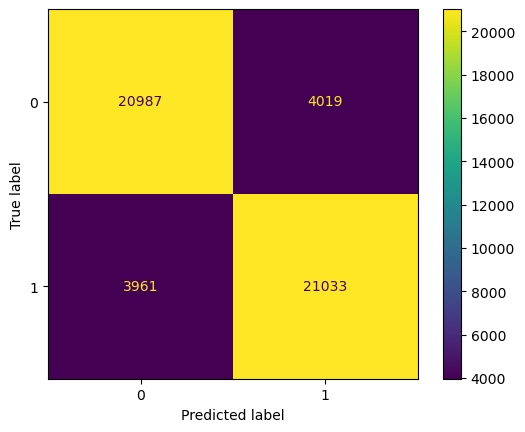

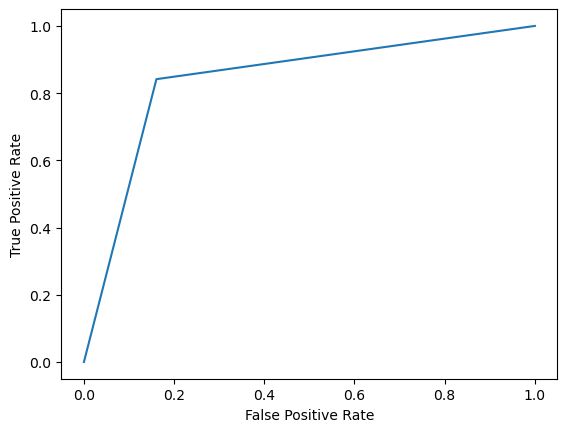

Column:  nltk_nltk_token_keras
Runtime for training: 874.82 sec
Accuracy:  84.092
Precision:  83.8323114897683
Recall:  84.39679358717434
F1-Score:  84.11360549652473


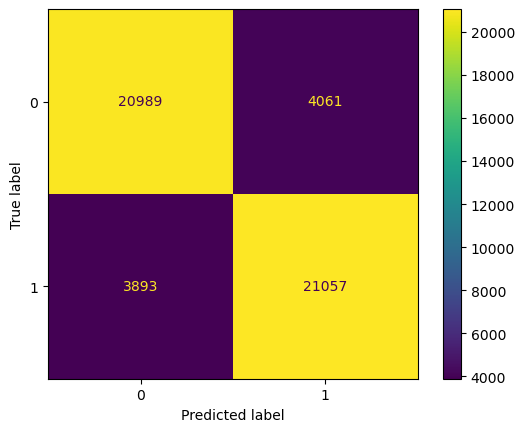

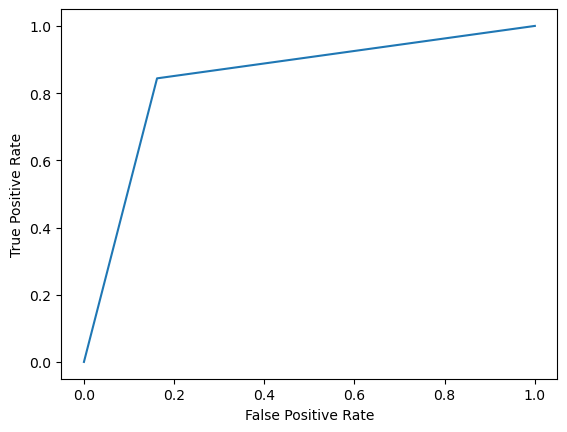

Column:  nltk_gensim_token_nltk
Runtime for training: 905.91 sec
Accuracy:  83.724
Precision:  83.91194918301306
Recall:  83.63129603822416
F1-Score:  83.7713875483588


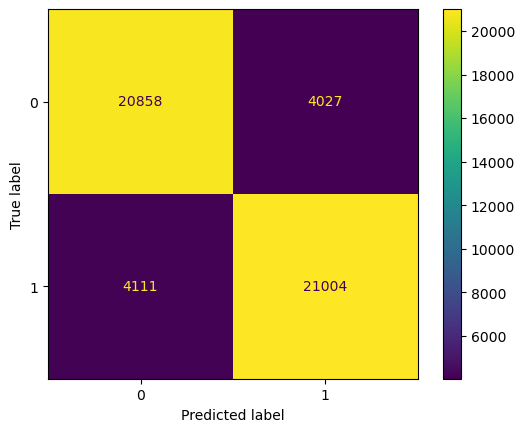

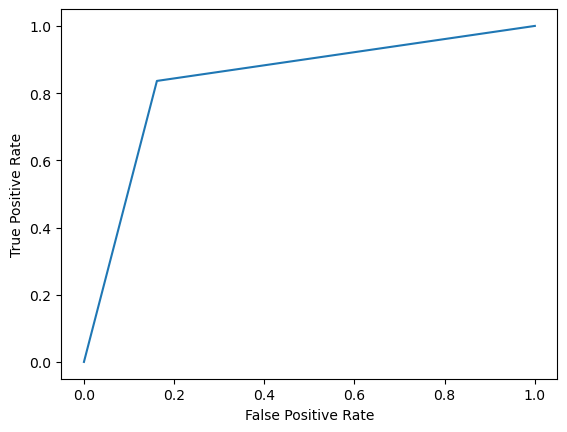

Column:  nltk_nltk_token_nltk
Runtime for training: 941.18 sec
Accuracy:  83.858
Precision:  84.11617789236223
Recall:  83.49394218081491
F1-Score:  83.80390504284311


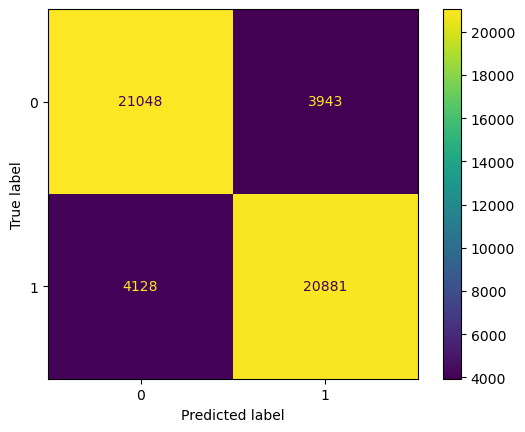

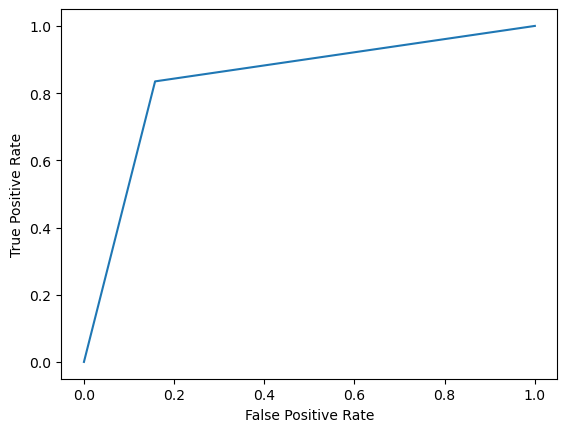

In [7]:
# Run the previous function on lemmatised columns
for col in tqdm(list(data_lemm.columns)[1:]):
    automatisation_word2vec_with_Random_Forest(data_lemm, col)

  0%|          | 0/4 [00:00<?, ?it/s]

Column:  nltk_stemmer_gensim_token_keras
Runtime for training: 948.97 sec
Accuracy:  83.43199999999999
Precision:  83.61347917001768
Recall:  83.16534677225822
F1-Score:  83.38881090836175


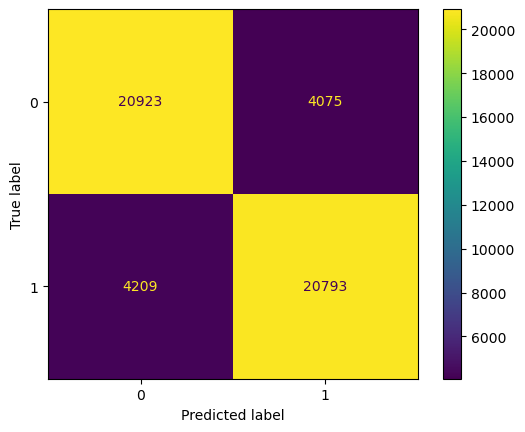

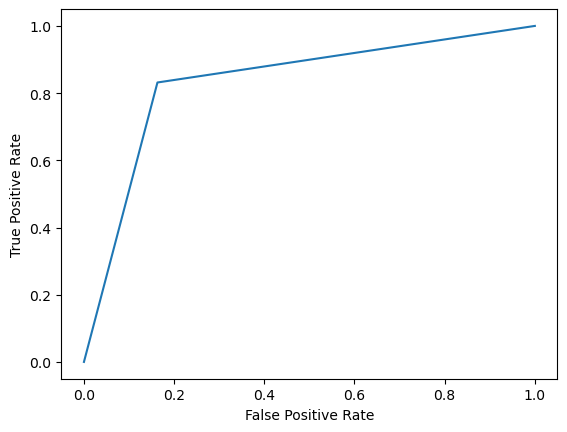

Column:  nltk_stemmer_nltk_token_keras
Runtime for training: 937.53 sec
Accuracy:  83.59400000000001
Precision:  83.38265877459607
Recall:  83.74101297345061
F1-Score:  83.56145167431514


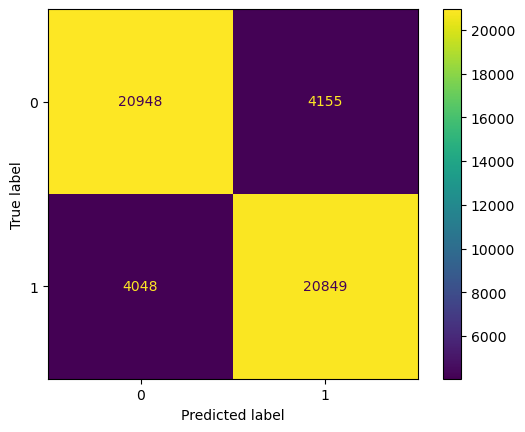

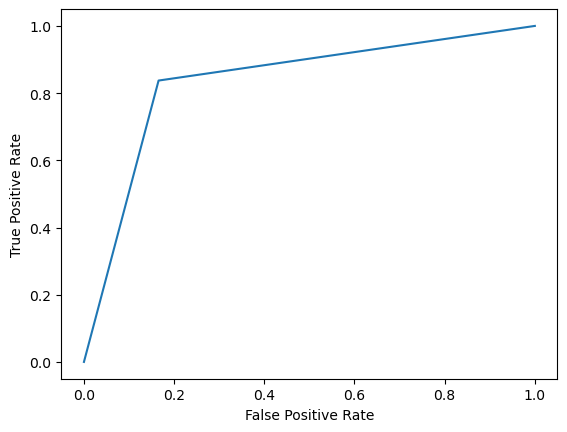

Column:  nltk_stemmer_gensim_token_nltk
Runtime for training: 959.05 sec
Accuracy:  83.64399999999999
Precision:  84.20711974110033
Recall:  82.96532483060982
F1-Score:  83.58161011845013


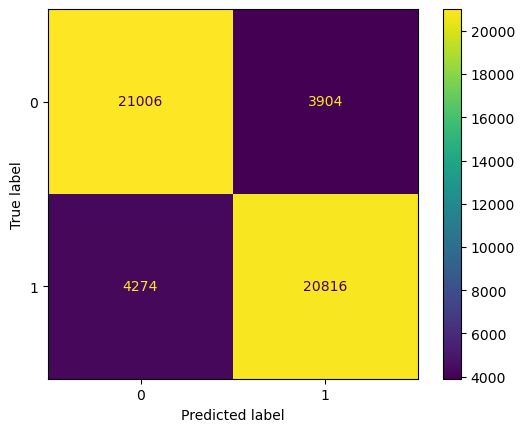

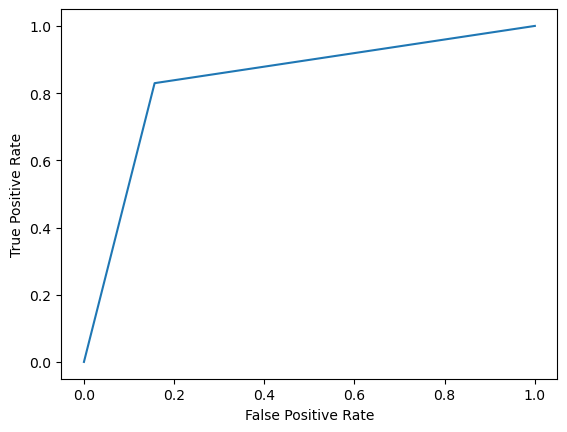

Column:  nltk_stemmer_nltk_token_nltk
Runtime for training: 953.08 sec
Accuracy:  83.824
Precision:  83.64685425229213
Recall:  84.27297340340819
F1-Score:  83.9587465291551


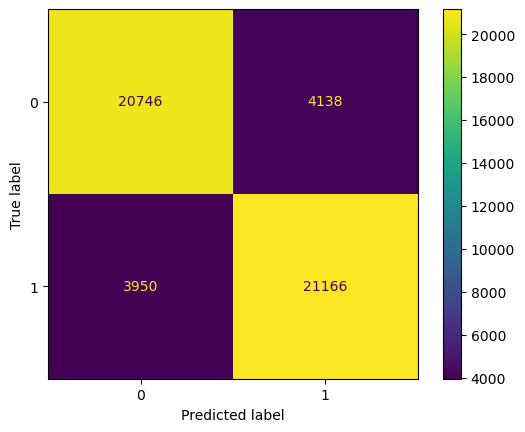

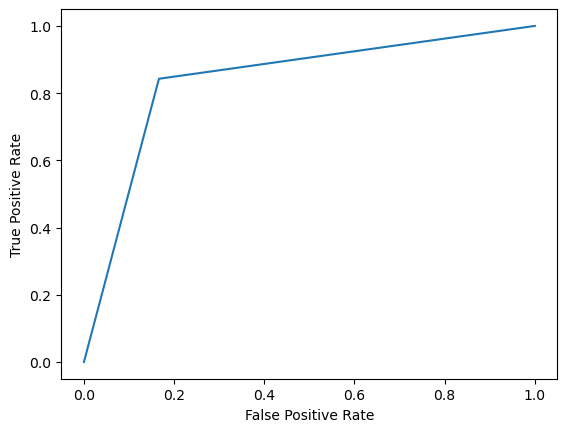

In [8]:
# Run the previous function on stemmed columns
for col in tqdm(list(data_stemm.columns)[1:]):
    automatisation_word2vec_with_Random_Forest(data_stemm, col)

### SVM

In [9]:
# Split the initial dataframe into two dataframes: one with lemmatised columns and one with stemmed columns
data_lemm = data[['label', 'nltk_gensim_token_keras', 'nltk_nltk_token_keras', 'nltk_gensim_token_nltk', 'nltk_nltk_token_nltk']].copy()
data_stemm = data[['label', 'nltk_stemmer_gensim_token_keras', 'nltk_stemmer_nltk_token_keras', 'nltk_stemmer_gensim_token_nltk', 'nltk_stemmer_nltk_token_nltk']].copy()

In [10]:
def automatisation_word2vec_with_SVM(data, column_name):
    
    # Display the name of the columns we are working on
    print("Column: ", column_name)
    
    # Change column type with ast.literal_eval()
    data[column_name] = data[column_name].apply(ast.literal_eval)

    # Create tokens
    tokens = data[column_name].values

    # Initialise the Word2Vec model
    w2v_model = Word2Vec(tokens, min_count=1, vector_size = 1000, workers = 3, window = 3, sg = 1)

    X = data[column_name]
    y = data['label']
    
    # Create train and test samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
    
    # Reset indexes
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Create empty dataframes
    df_train = pd.DataFrame(columns=[str(i) for i in range(1000)], index=[i for i in range(len(X_train))])
    df_test = pd.DataFrame(columns=[str(i) for i in range(1000)], index=[i for i in range(len(X_test))])
    
    # Fill those dataframes with the associated vectors
    for idx, row in X_train.items():
        model_vector = (np.mean([w2v_model.wv[token] for token in row], axis=0)).tolist()

        df_train.loc[idx] = model_vector

    for idx, row in X_test.items():
        model_vector = (np.mean([w2v_model.wv[token] for token in row], axis=0)).tolist()

        df_test.loc[idx] = model_vector
    
    # Drop NaN vectors if necessary
    df_train.dropna(inplace=True)
    y_train = [int(y_train[i]) for i in df_train.index.tolist()]
    df_train.reset_index(drop=True, inplace=True)
    
    # Drop NaN vectors if necessary
    df_test.dropna(inplace=True)
    y_test = [int(y_test[i]) for i in df_test.index.tolist()]
    df_test.reset_index(drop=True, inplace=True)
    
    # Convert dataframes to numpy arrays
    X_train = df_train.to_numpy()
    X_test = df_test.to_numpy()
    
    # Initialise SVM model
    classifier_linear = svm.SVC(kernel="linear", class_weight="balanced")
    start = time.time()
    classifier_linear_fit = classifier_linear.fit(X_train[:50000], y_train[:50000])
    end = time.time()
    print("Runtime for training:", round(end - start, 2), "sec")
    
    # Make the predictions
    predictions = classifier_linear_fit.predict(X_test[:12500])
    
    # Display metrics scores
    print("Accuracy: ", accuracy_score(y_test[:12500],predictions)*100)
    print("Precision: ", precision_score(y_test[:12500],predictions.astype(int))*100)
    print("Recall: ", recall_score(y_test[:12500],predictions.astype(int))*100)
    print("F1-Score: ", f1_score(y_test[:12500],predictions.astype(int))*100)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test[:12500], predictions, labels=classifier_linear_fit.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier_linear_fit.classes_)
    disp.plot()
    plt.show()

    fpr, tpr, _ = metrics.roc_curve(y_test[:12500], predictions.astype(int))

    # Create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

Column:  nltk_gensim_token_keras
Runtime for training: 1378.31 sec
Accuracy:  86.888
Precision:  86.8421052631579
Recall:  86.5748987854251
F1-Score:  86.70829616413917


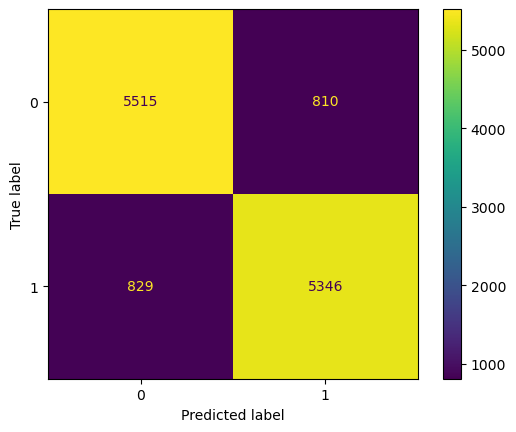

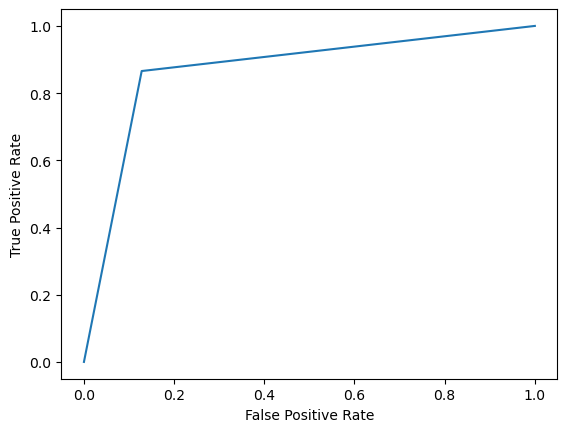

Column:  nltk_nltk_token_keras
Runtime for training: 1294.76 sec
Accuracy:  87.488
Precision:  87.57637474541752
Recall:  87.87926426662474
F1-Score:  87.72755806654112


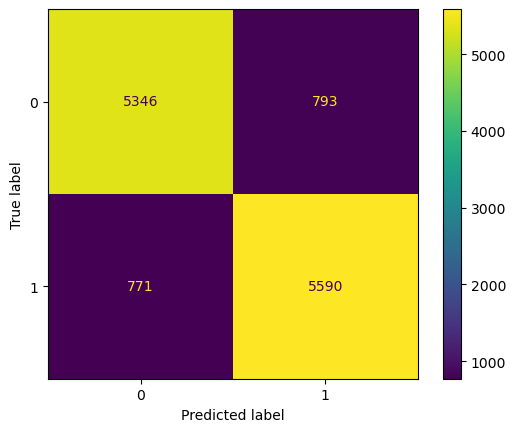

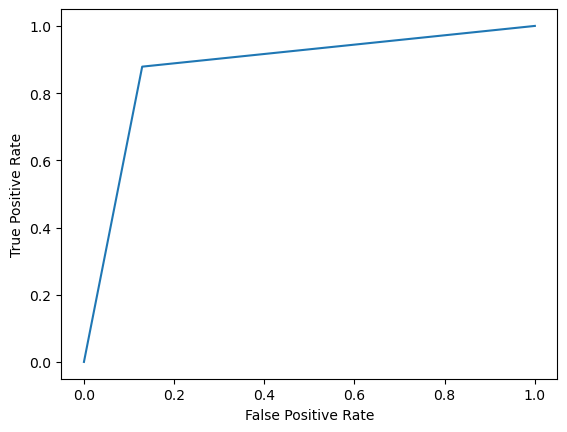

Column:  nltk_gensim_token_nltk
Runtime for training: 1258.54 sec
Accuracy:  87.048
Precision:  86.77172874880611
Recall:  87.36977079660203
F1-Score:  87.06972286558582


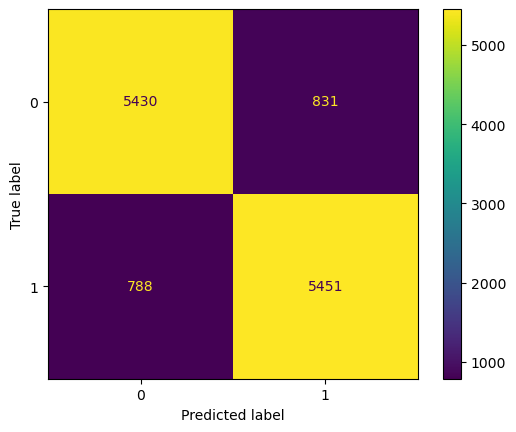

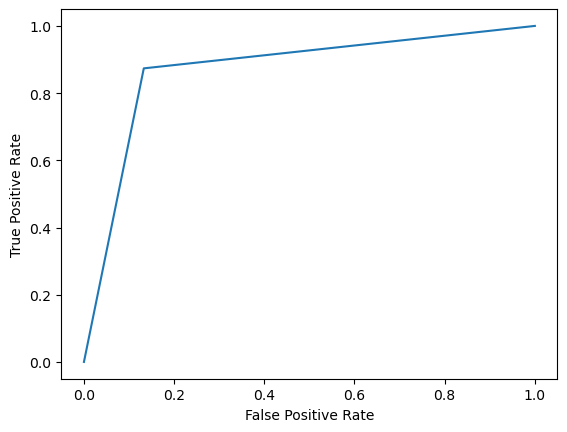

Column:  nltk_nltk_token_nltk
Runtime for training: 1481.14 sec
Accuracy:  87.408
Precision:  87.08421223430148
Recall:  87.3393002441009
F1-Score:  87.21156971075722


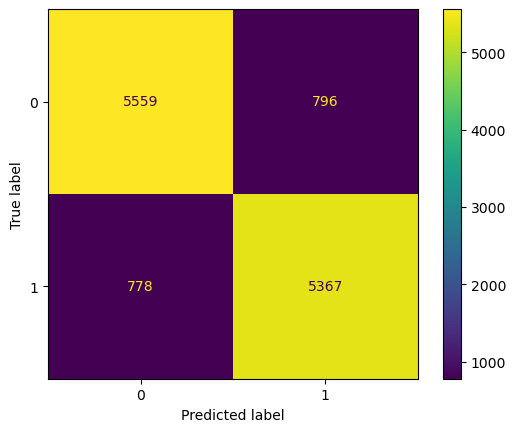

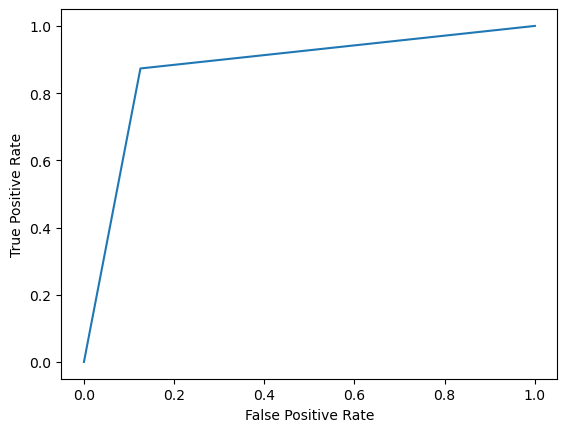

In [11]:
# Run the previous function on lemmatised columns
for col in tqdm(list(data_lemm.columns)[1:]):
    automatisation_word2vec_with_SVM(data_lemm, col)

  0%|          | 0/4 [00:00<?, ?it/s]

Column:  nltk_stemmer_gensim_token_keras
Runtime for training: 1331.29 sec
Accuracy:  86.624
Precision:  86.61804344379262
Recall:  86.83834048640917
F1-Score:  86.72805207175743


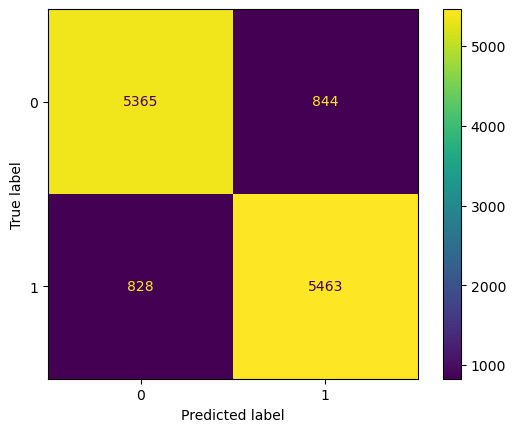

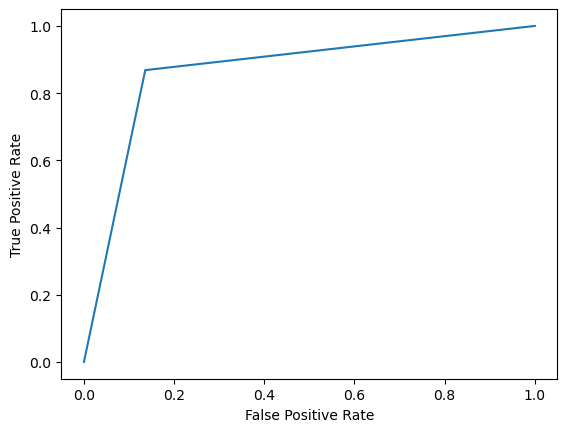

Column:  nltk_stemmer_nltk_token_keras
Runtime for training: 1311.91 sec
Accuracy:  86.4
Precision:  85.77827547592385
Recall:  86.8621415843188
F1-Score:  86.31680618158403


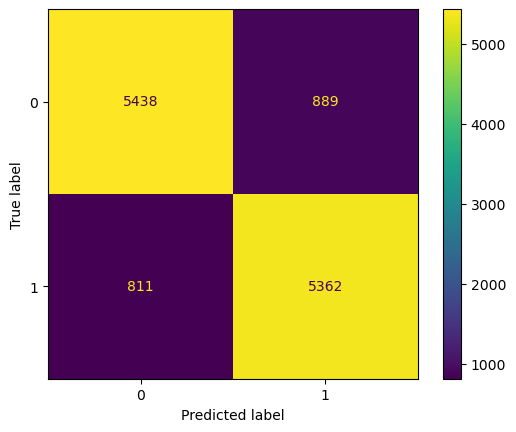

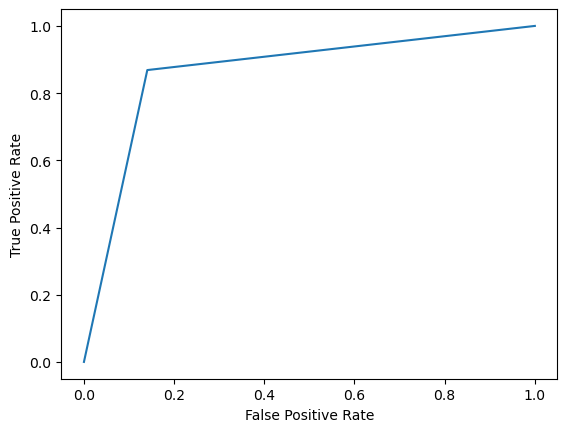

Column:  nltk_stemmer_gensim_token_nltk
Runtime for training: 1160.82 sec
Accuracy:  87.232
Precision:  87.3330114276517
Recall:  87.02485966319166
F1-Score:  87.17866323907455


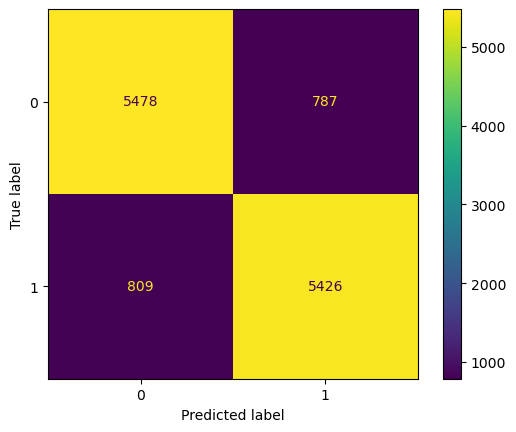

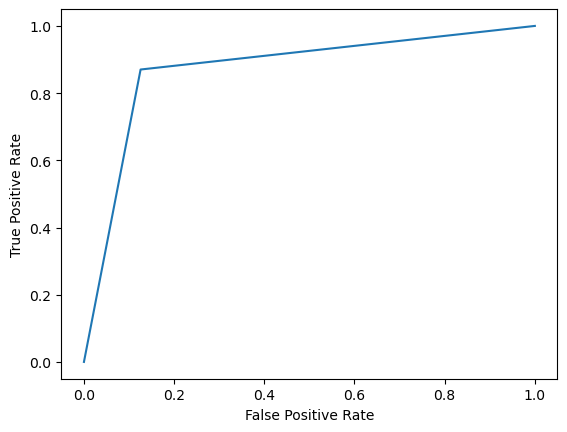

Column:  nltk_stemmer_nltk_token_nltk
Runtime for training: 1293.68 sec
Accuracy:  86.944
Precision:  86.58868771030284
Recall:  87.17535086304242
F1-Score:  86.88102893890675


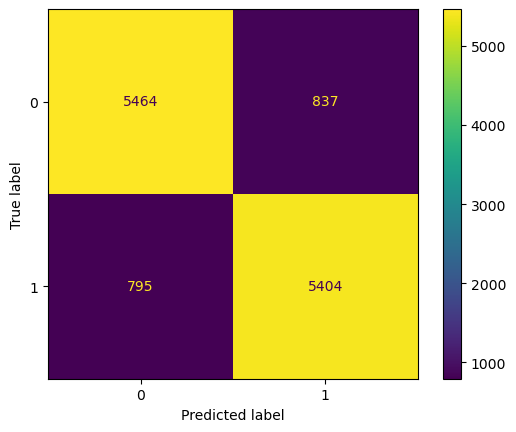

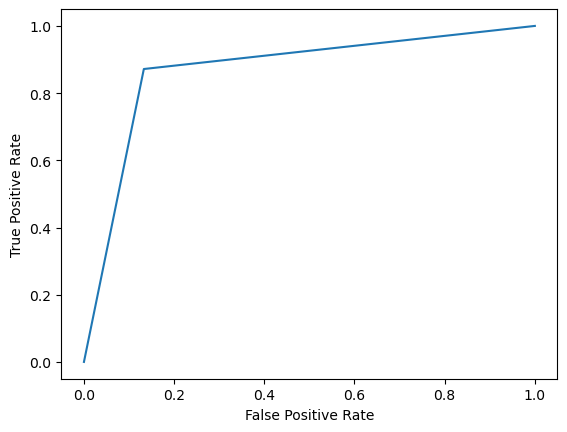

In [12]:
# Run the previous function on stemmed columns
for col in tqdm(list(data_stemm.columns)[1:]):
    automatisation_word2vec_with_SVM(data_stemm, col)

## GloVe

In [13]:
# Load GloVe dictionary
embeddings_dict = {}
path_to_glov_dict = "/kaggle/input/glove-dictionary/glove.twitter.27B.100d.txt"
glove = open(path_to_glov_dict, encoding="utf8")

# Create the words embeddings
for line in glove:
    values = line.split()
    word = values[0]
    word = word.replace('<', '').replace('>', '')
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

### Random Forest

In [14]:
def automatisation_glove_with_Random_Forest(data, column_name):
    
    # Display the name of the columns we are working on
    print("Column: ", column_name)

    X = data[column_name]
    y = data['label']
    
    # Create train and test samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
    
    # Reset indexes
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Create empty dataframes regarding the dimension of the GloVe words embedding
    df_train = pd.DataFrame(columns=[str(i) for i in range(100)], index=[i for i in range(len(X_train))])
    df_test = pd.DataFrame(columns=[str(i) for i in range(100)], index=[i for i in range(len(X_test))])
    
    # Fill those dataframes with the associated vectors
    for idx, row in X_train.items():
        vect = []

        for token in row:
            if embeddings_dict.get(token) is not None:
                vect.append(embeddings_dict[token])

        model_vector = (np.mean(vect, axis=0)).tolist()

        df_train.loc[idx] = model_vector

    for idx, row in X_test.items():
        vect = []
        
        for token in row:
            if embeddings_dict.get(token) is not None:
                vect.append(embeddings_dict[token])

        model_vector = (np.mean(vect, axis=0)).tolist()

        df_test.loc[idx] = model_vector
    
    # Drop NaN vectors if necessary
    df_train.dropna(inplace=True)
    y_train = [int(y_train[i]) for i in df_train.index.tolist()]
    df_train.reset_index(drop=True, inplace=True)
    
    # Drop NaN vectors if necessary
    df_test.dropna(inplace=True)
    y_test = [int(y_test[i]) for i in df_test.index.tolist()]
    df_test.reset_index(drop=True, inplace=True)
    
    # Initialise Random Forest model
    rf = RandomForestClassifier()
    start = time.time()
    rf_fit = rf.fit(df_train, y_train)
    end = time.time()
    print("Runtime for training:", round(end - start, 2), "sec")
    
    # Make predictions
    predictions = rf_fit.predict(df_test)
    
    # Display metrics scores
    print("Accuracy: ", accuracy_score(y_test,predictions)*100)
    print("Precision: ", precision_score(y_test,predictions.astype(int))*100)
    print("Recall: ", recall_score(y_test,predictions.astype(int))*100)
    print("F1-Score: ", f1_score(y_test,predictions.astype(int))*100)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, predictions, labels=rf_fit.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_fit.classes_)
    disp.plot()
    plt.show()

    fpr, tpr, _ = metrics.roc_curve(y_test, predictions.astype(int))

    # Create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

Column:  nltk_gensim_token_keras
Runtime for training: 283.55 sec
Accuracy:  78.00399999999999
Precision:  79.04773723835525
Recall:  76.30780289114288
F1-Score:  77.65360858257476


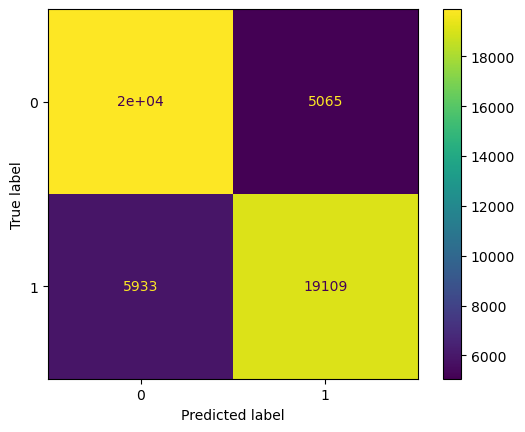

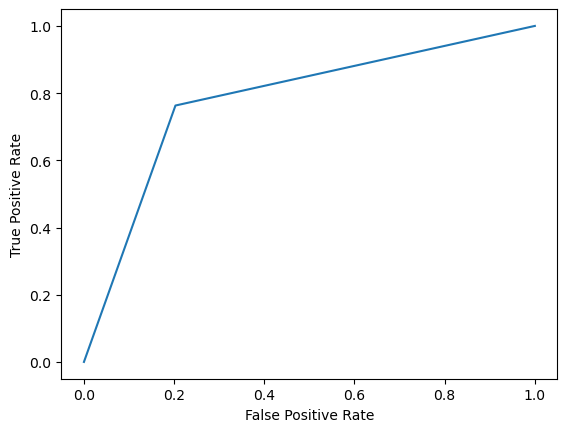

Column:  nltk_nltk_token_keras
Runtime for training: 289.73 sec
Accuracy:  77.858
Precision:  78.71250309891744
Recall:  76.29460531058513
F1-Score:  77.48469626405809


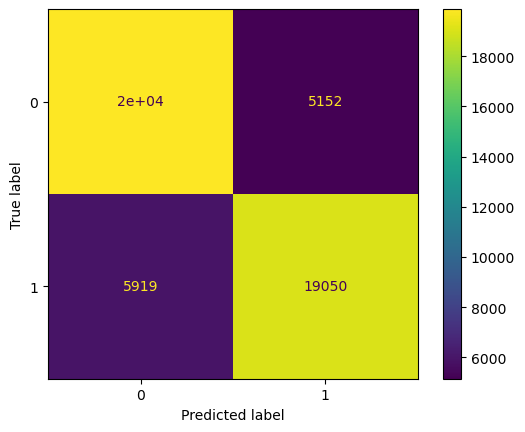

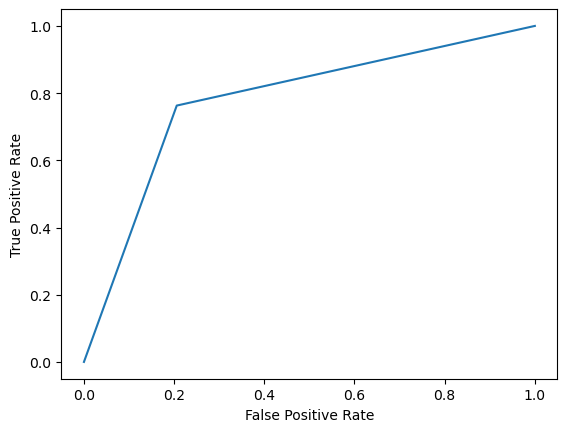

Column:  nltk_gensim_token_nltk


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Runtime for training: 281.23 sec
Accuracy:  75.86109542631281
Precision:  76.8235491164894
Recall:  74.03357275441853
F1-Score:  75.40276179516685


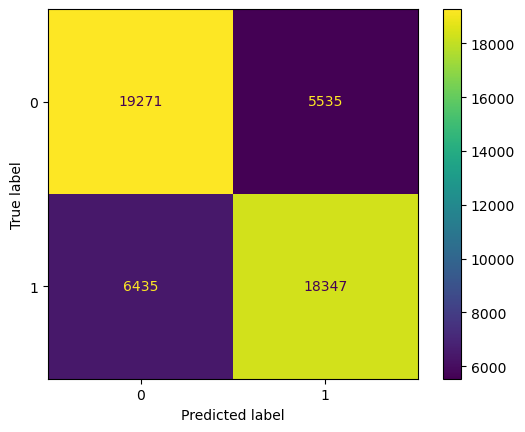

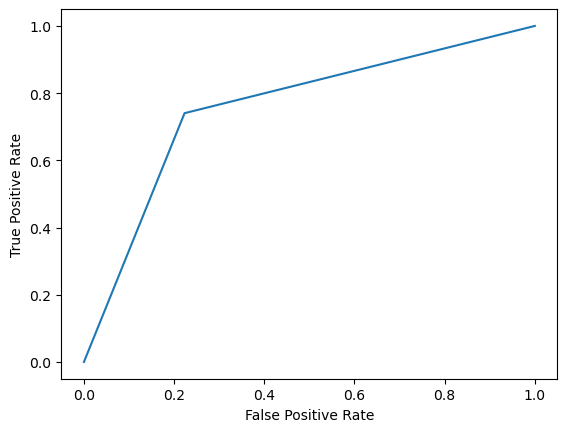

Column:  nltk_nltk_token_nltk


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Runtime for training: 279.24 sec
Accuracy:  76.40116208691443
Precision:  77.15003138731952
Recall:  74.72033073929961
F1-Score:  75.91574525912657


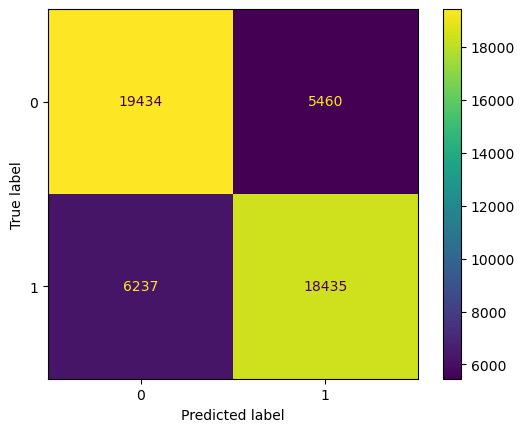

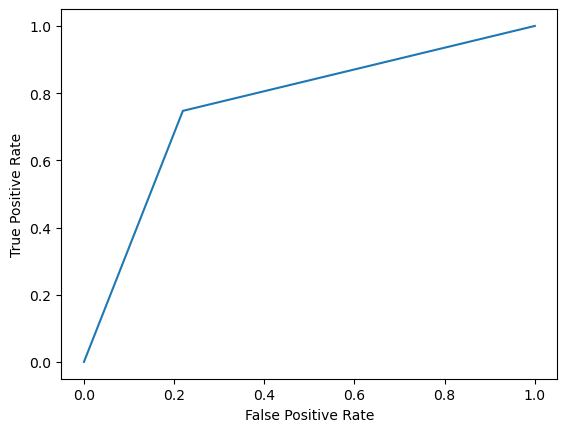

In [15]:
# Run the previous function on lemmatised columns
for col in tqdm(list(data_lemm.columns)[1:]):
    automatisation_glove_with_Random_Forest(data_lemm, col)

  0%|          | 0/4 [00:00<?, ?it/s]

Column:  nltk_stemmer_gensim_token_keras
Runtime for training: 281.46 sec
Accuracy:  74.832
Precision:  75.4325259515571
Recall:  73.44777795604043
F1-Score:  74.42692245163389


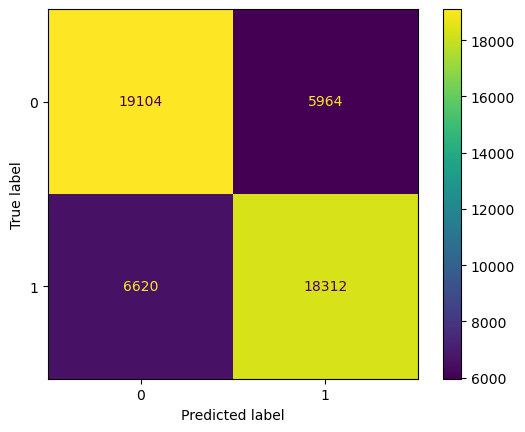

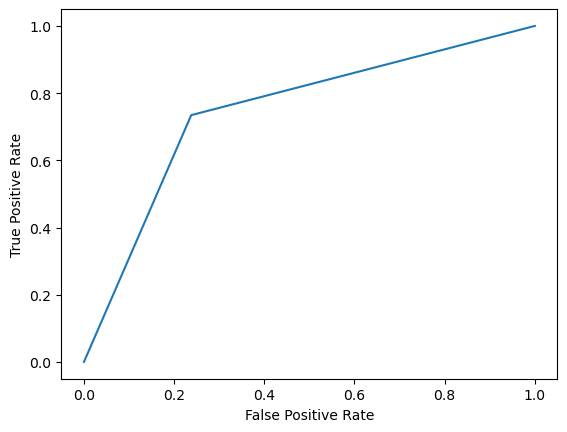

Column:  nltk_stemmer_nltk_token_keras
Runtime for training: 284.79 sec
Accuracy:  74.272
Precision:  75.19829038753956
Recall:  72.82206391531022
F1-Score:  73.9911039223615


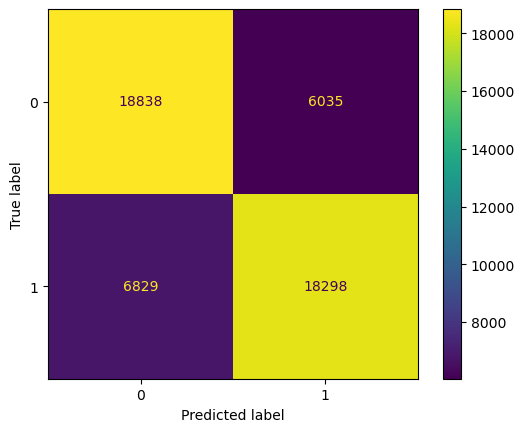

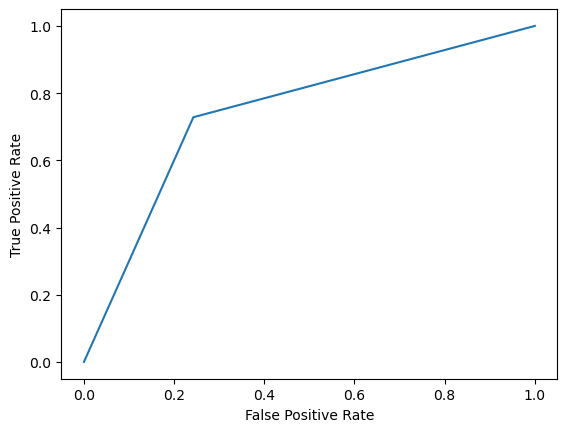

Column:  nltk_stemmer_gensim_token_nltk
Runtime for training: 284.3 sec
Accuracy:  75.086
Precision:  75.65356790529432
Recall:  73.80007217610971
F1-Score:  74.71532668926463


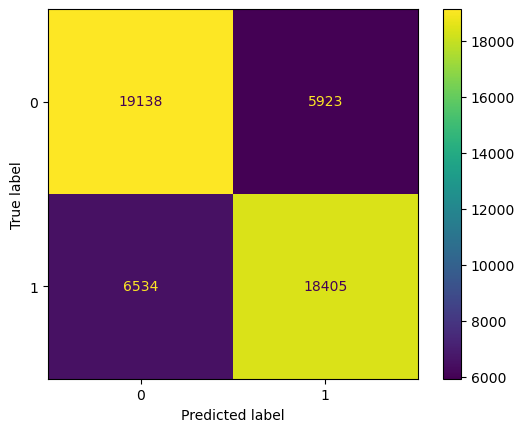

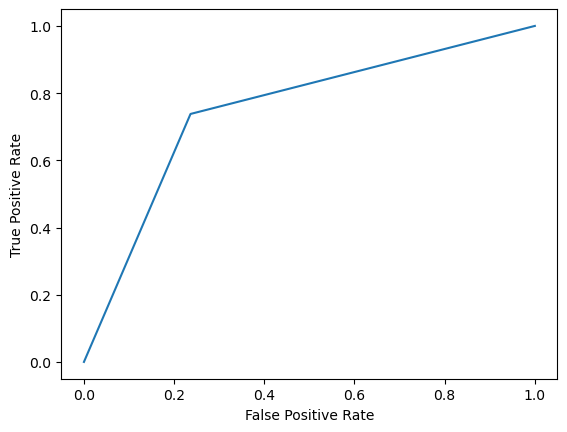

Column:  nltk_stemmer_nltk_token_nltk
Runtime for training: 283.4 sec
Accuracy:  74.476
Precision:  75.38238941711451
Recall:  72.81766632058142
F1-Score:  74.07783555411115


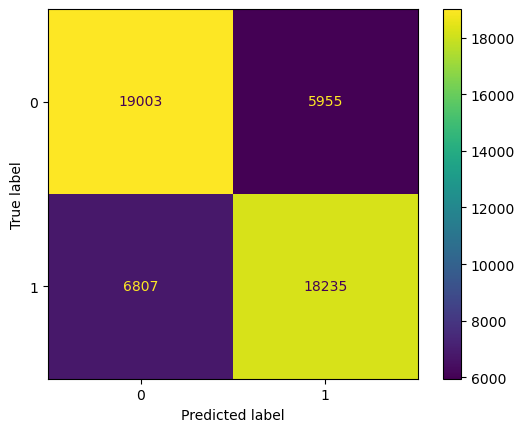

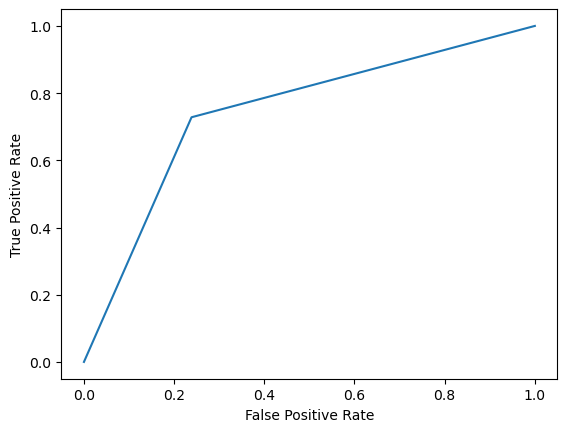

In [16]:
# Run the previous function on stemmed columns
for col in tqdm(list(data_stemm.columns)[1:]):
    automatisation_glove_with_Random_Forest(data_stemm, col)

### SVM

In [17]:
def automatisation_glove_with_SVM(data, column_name):
    
    # Display the name of the columns we are working on
    print("Column: ", column_name)

    X = data[column_name]
    y = data['label']
    
    # Create train and test samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
    
    # Reset indexes
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    # Create empty dataframes regarding the dimension of the GloVe words embedding
    df_train = pd.DataFrame(columns=[str(i) for i in range(100)], index=[i for i in range(len(X_train))])
    df_test = pd.DataFrame(columns=[str(i) for i in range(100)], index=[i for i in range(len(X_test))])
    
    # Fill those dataframes with the associated vectors
    for idx, row in X_train.items():
        vect = []

        for token in row:
            if embeddings_dict.get(token) is not None:
                vect.append(embeddings_dict[token])

        model_vector = (np.mean(vect, axis=0)).tolist()

        df_train.loc[idx] = model_vector

    for idx, row in X_test.items():
        vect = []
        
        for token in row:
            if embeddings_dict.get(token) is not None:
                vect.append(embeddings_dict[token])

        model_vector = (np.mean(vect, axis=0)).tolist()

        df_test.loc[idx] = model_vector
    
    # Drop NaN vectors if necessary
    df_train.dropna(inplace=True)
    y_train = [int(y_train[i]) for i in df_train.index.tolist()]
    df_train.reset_index(drop=True, inplace=True)
    
    # Drop NaN vectors if necessary
    df_test.dropna(inplace=True)
    y_test = [int(y_test[i]) for i in df_test.index.tolist()]
    df_test.reset_index(drop=True, inplace=True)
    
    # Convert dataframes to numpy arrays
    X_train = df_train.to_numpy()
    X_test = df_test.to_numpy()
    
    # Initialise SVM model
    classifier_linear = svm.SVC(kernel="linear", class_weight="balanced")
    start = time.time()
    classifier_linear_fit = classifier_linear.fit(X_train[:50000], y_train[:50000])
    end = time.time()
    print("Runtime for training:", round(end - start, 2), "sec")
    
    # Make predictions
    predictions = classifier_linear_fit.predict(X_test[:12500])
    
    # Display metrics scores
    print("Accuracy: ", accuracy_score(y_test[:12500],predictions.astype(int))*100)
    print("Precision: ", precision_score(y_test[:12500],predictions.astype(int))*100)
    print("Recall: ", recall_score(y_test[:12500],predictions.astype(int))*100)
    print("F1-Score: ", f1_score(y_test[:12500],predictions.astype(int))*100)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test[:12500], predictions, labels=classifier_linear_fit.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier_linear_fit.classes_)
    disp.plot()
    plt.show()

    fpr, tpr, _ = metrics.roc_curve(y_test[:12500], predictions.astype(int))

    # Create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

Column:  nltk_gensim_token_keras
Runtime for training: 327.42 sec
Accuracy:  80.05600000000001
Precision:  81.19658119658119
Recall:  78.54984894259819
F1-Score:  79.85128909722783


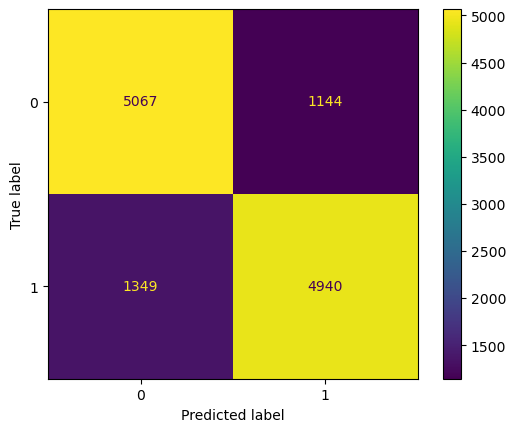

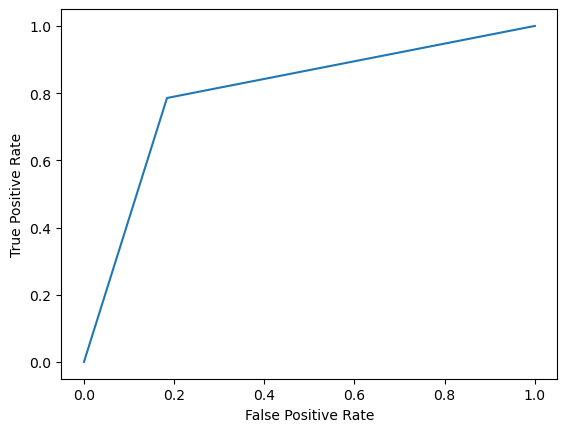

Column:  nltk_nltk_token_keras
Runtime for training: 349.99 sec
Accuracy:  79.42399999999999
Precision:  80.33349681216283
Recall:  78.21104567881585
F1-Score:  79.25806451612902


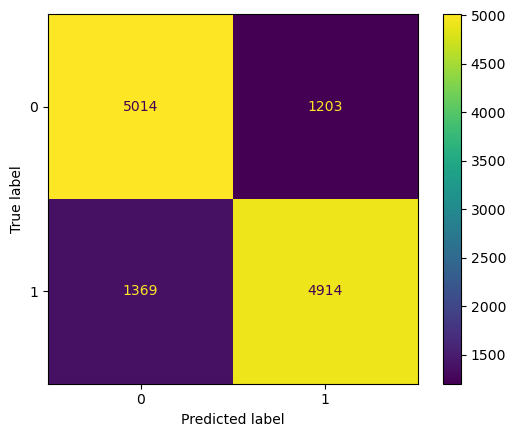

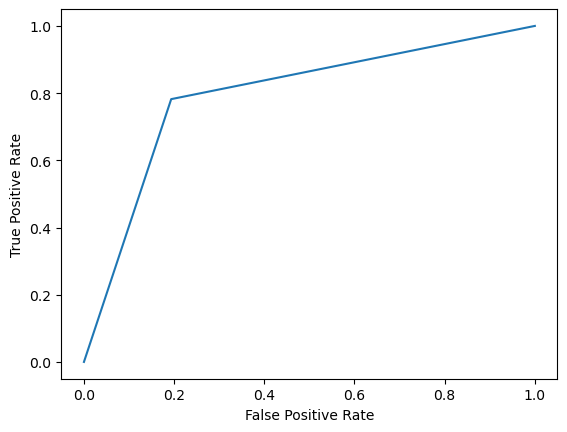

Column:  nltk_gensim_token_nltk


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Runtime for training: 391.25 sec
Accuracy:  77.776
Precision:  78.00423936083483
Recall:  76.99983904715918
F1-Score:  77.49878503158916


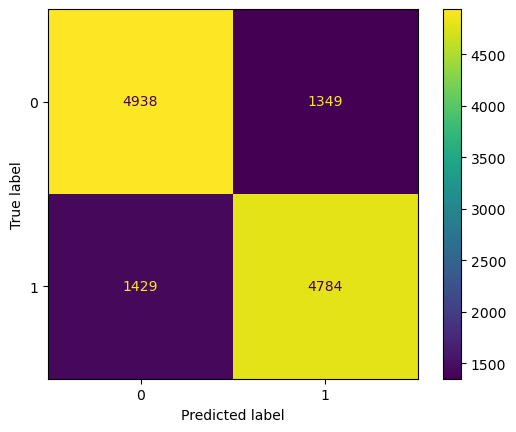

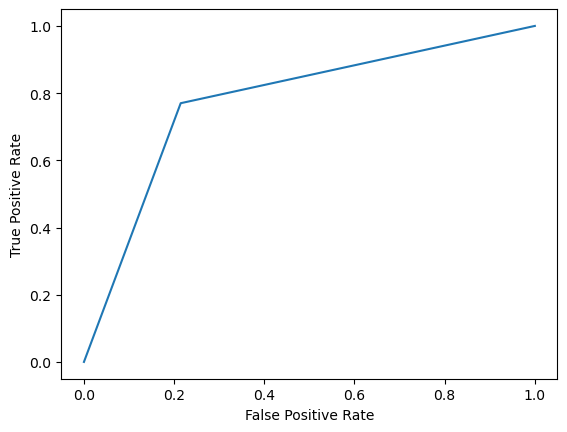

Column:  nltk_nltk_token_nltk


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Runtime for training: 394.77 sec
Accuracy:  78.216
Precision:  78.65440464666021
Recall:  77.68924302788844
F1-Score:  78.16884470456186


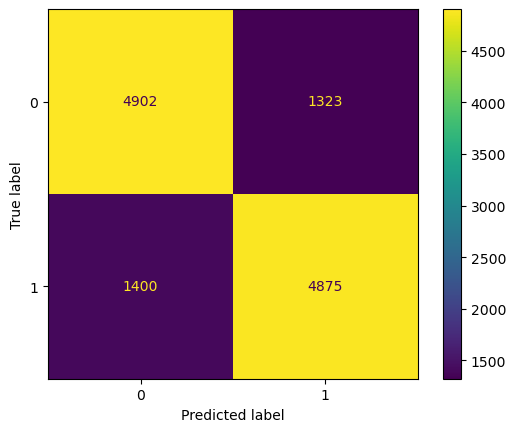

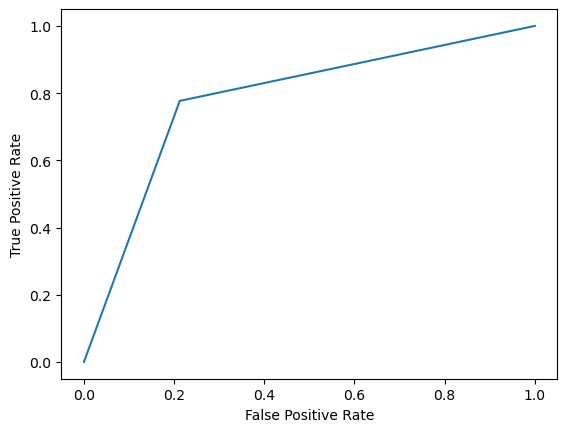

In [18]:
# Run the previous function on lemmatised columns
for col in tqdm(list(data_lemm.columns)[1:]):
    automatisation_glove_with_SVM(data_lemm, col)

  0%|          | 0/4 [00:00<?, ?it/s]

Column:  nltk_gensim_token_keras
Runtime for training: 317.98 sec
Accuracy:  79.928
Precision:  80.88888888888889
Recall:  78.47333120408815
F1-Score:  79.66280295047416


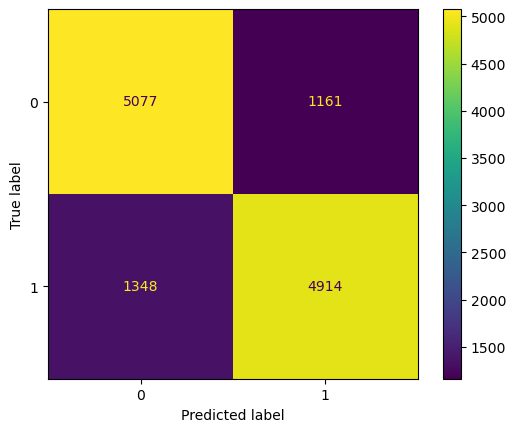

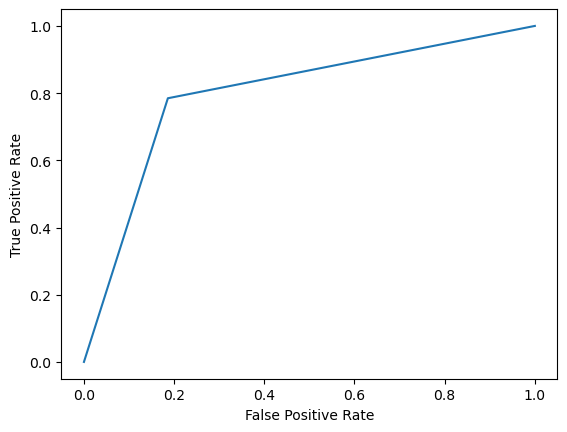

Column:  nltk_nltk_token_keras
Runtime for training: 360.39 sec
Accuracy:  79.67999999999999
Precision:  80.78502217112826
Recall:  78.21593258069646
F1-Score:  79.47972208757473


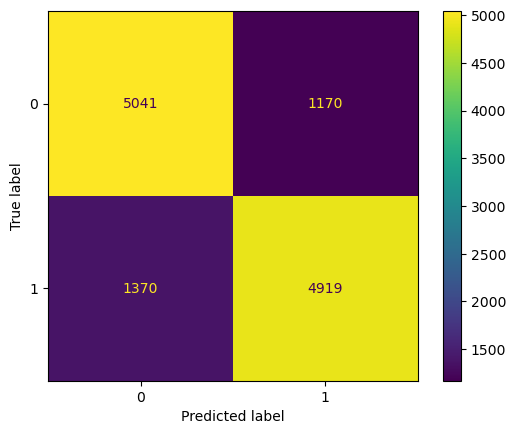

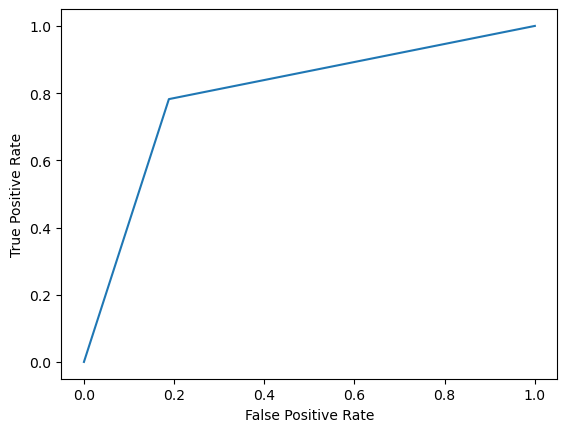

Column:  nltk_gensim_token_nltk


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Runtime for training: 370.4 sec
Accuracy:  77.32
Precision:  78.25726141078839
Recall:  75.56089743589743
F1-Score:  76.88544639217285


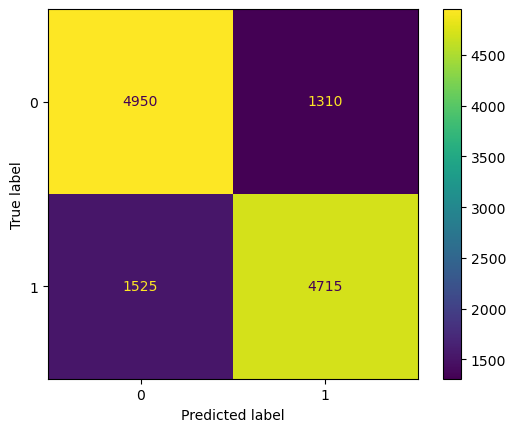

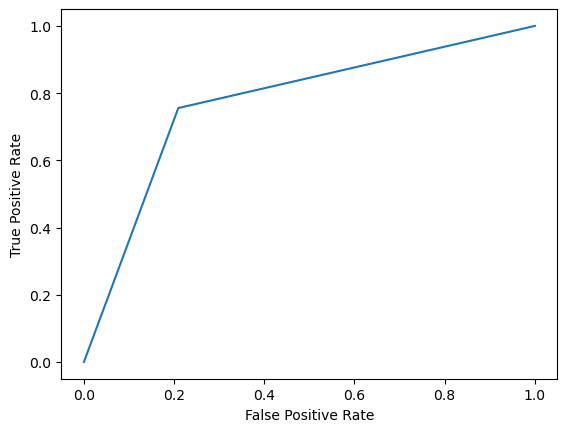

Column:  nltk_nltk_token_nltk


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Runtime for training: 390.63 sec
Accuracy:  77.84
Precision:  78.40719760079973
Recall:  76.14886731391586
F1-Score:  77.2615334099491


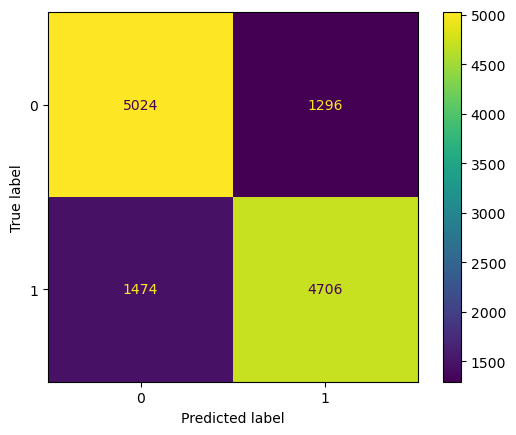

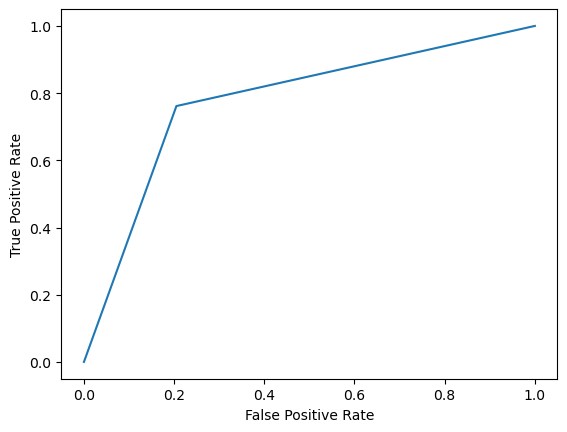

In [19]:
# Run the previous function on stemmed columns
for col in tqdm(list(data_lemm.columns)[1:]):
    automatisation_glove_with_SVM(data_lemm, col)

## TF-IDF

### Random Forest

In [20]:
# Split the initial dataframe into two dataframes: one with lemmatised columns and one with stemmed columns
data_lemm = data[['label', 'nltk_gensim_token_keras', 'nltk_nltk_token_keras', 'nltk_gensim_token_nltk', 'nltk_nltk_token_nltk']].copy()
data_stemm = data[['label', 'nltk_stemmer_gensim_token_keras', 'nltk_stemmer_nltk_token_keras', 'nltk_stemmer_gensim_token_nltk', 'nltk_stemmer_nltk_token_nltk']].copy()

In [21]:
def automatisation_tfidf_with_Random_Forest(data, column_name):
    
    # Display the name of the columns we are working on
    print("Column: ", column_name)
    
    # Change column type with ast.literal_eval()
    data[column_name] = data[column_name].apply(ast.literal_eval)
    
    # Join tokens from that specific column
    join_list = []

    for l in data[column_name]:
        join_list.append(' '.join(l))
    
    # Create a new column
    data['join_text'] = join_list
    
    # Initialise TF-IDF model
    vectorizer = TfidfVectorizer()
    
    # Fit with data
    X_tfidf = vectorizer.fit_transform(data['join_text'])
    words = vectorizer.get_feature_names_out()
    
    # Create a dataframe from it
    X_tfidf_df = pd.DataFrame.sparse.from_spmatrix(X_tfidf)
    X_tfidf_df.columns = words
    
    # List columns useless for sentiment analysis
    delete_col = []

    for col in X_tfidf_df.columns:
        if any(ele.isdigit() for ele in col):
            delete_col.append(col)
        else:
            if not re.match('^[a-zA-Z_]+$', col):
                delete_col.append(col)
            
            else:
                if len(col) > 20:
                    delete_col.append(col)
                else:
                    if len(col) > 2:
                        if (col[0]==col[1]) & (col[1]==col[2]):
                            delete_col.append(col)
                    if len(col) > 1:
                        if (col[0]==col[1]):
                            delete_col.append(col)

    # Delete those columns                        
    X_tfidf_df.drop(columns=delete_col, inplace=True)
    
    # Create train and test samples
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf_df, data['label'].values.ravel(), test_size = 0.25, shuffle=True)
    
    # Reset indexes
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    
    # Drop NaN vectors if necessary
    X_train.dropna(inplace=True)
    y_train = [int(y_train[i]) for i in X_train.index.tolist()]
    X_train.reset_index(drop=True, inplace=True)
    
    # Drop NaN vectors if necessary
    X_test.dropna(inplace=True)
    y_test = [int(y_test[i]) for i in X_test.index.tolist()]
    X_test.reset_index(drop=True, inplace=True)
    
    # Initialise Random Forest model
    rf = RandomForestClassifier()
    start = time.time()
    rf_fit = rf.fit(X_train, y_train)
    end = time.time()
    print("Runtime for training:", round(end - start, 2), "sec")
    
    # Make predictions
    predictions = rf_fit.predict(X_test)
    
    # Display metrics scores
    print("Accuracy: ", accuracy_score(y_test,predictions)*100)
    print("Precision: ", precision_score(y_test,predictions.astype(int))*100)
    print("Recall: ", recall_score(y_test,predictions.astype(int))*100)
    print("F1-Score: ", f1_score(y_test,predictions.astype(int))*100)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, predictions, labels=rf_fit.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_fit.classes_)
    disp.plot()
    plt.show()

    fpr, tpr, _ = metrics.roc_curve(y_test, predictions.astype(int))

    # Create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

Runtime for training: 5477.52 sec
Accuracy:  86.29599999999999
Precision:  87.28973496348567
Recall:  85.00199760287654
F1-Score:  86.13067767792081


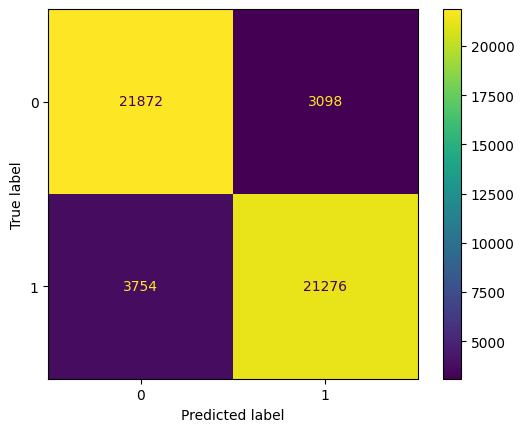

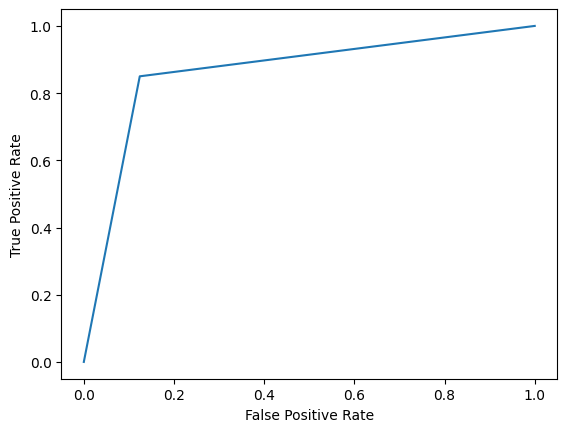

Runtime for training: 4719.64 sec
Accuracy:  86.396
Precision:  87.48308247549522
Recall:  85.0484430445357
F1-Score:  86.24858482937086


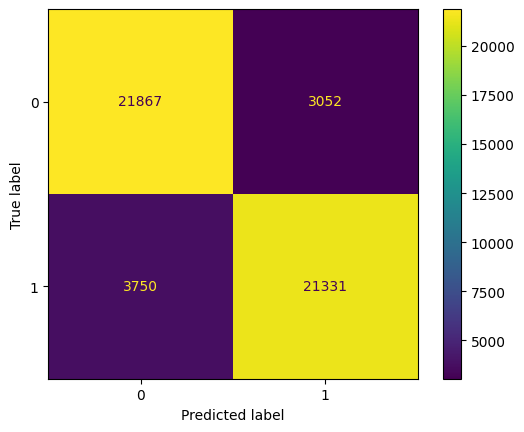

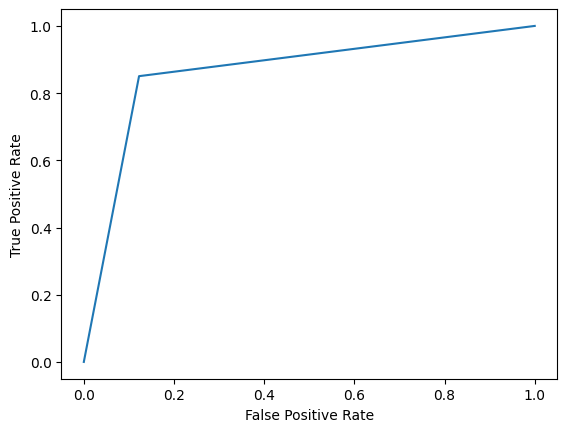

Runtime for training: 5646.12 sec
Accuracy:  86.26
Precision:  87.50362063971532
Recall:  84.59815177821338
F1-Score:  86.02636075176959


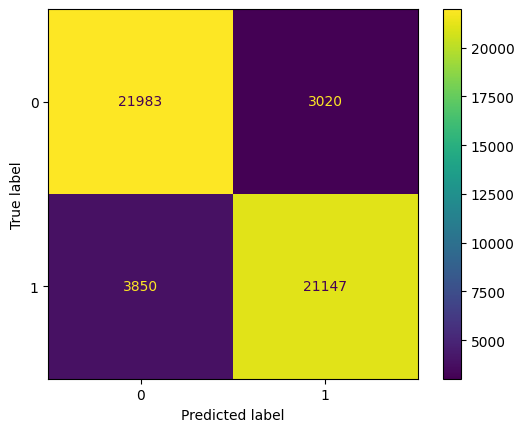

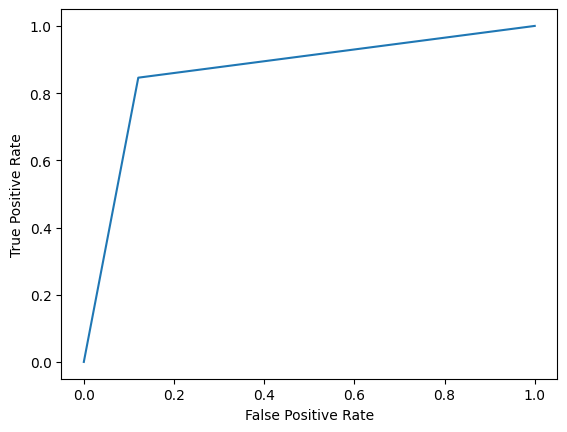

Runtime for training: 4793.3 sec
Accuracy:  85.908
Precision:  87.1408075425292
Recall:  84.46775539396829
F1-Score:  85.78346313708083


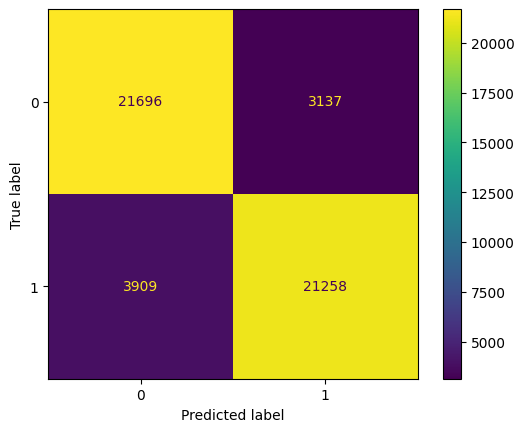

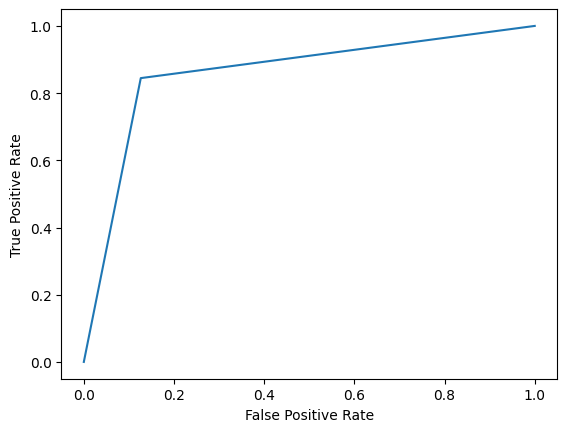

In [ ]:
# Run the previous function on lemmatised columns
for col in tqdm(list(data_lemm.columns)[1:]):
    automatisation_tfidf_with_Random_Forest(data_lemm, col)

  0%|          | 0/4 [00:00<?, ?it/s]

Runtime for training: 4847.83 sec
Accuracy:  86.176
Precision:  87.02771296410005
Recall:  85.02979642442907
F1-Score:  86.01715487943032


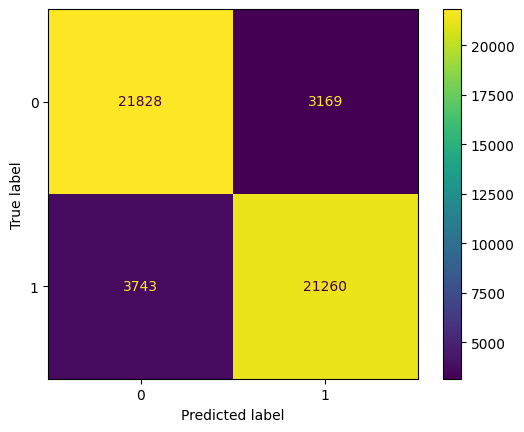

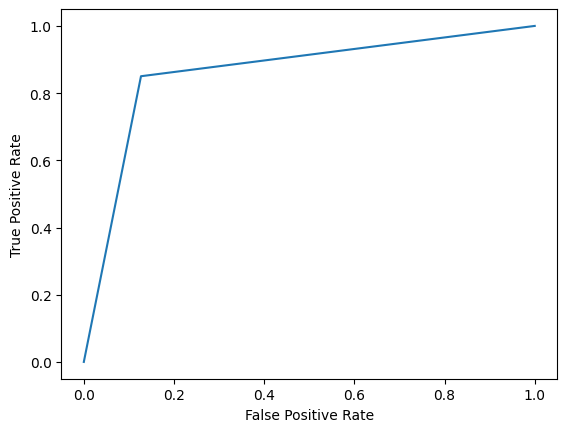

Runtime for training: 4133.6 sec
Accuracy:  85.776
Precision:  86.91695572332178
Recall:  84.50307478674867
F1-Score:  85.69301951317642


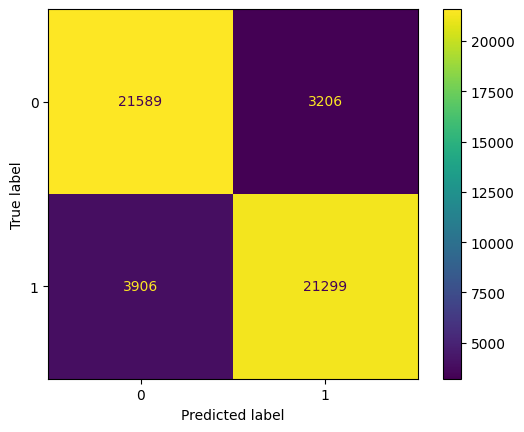

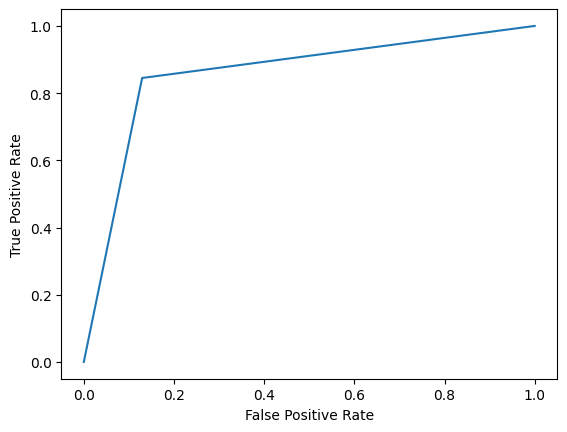

Runtime for training: 4854.79 sec
Accuracy:  86.332
Precision:  87.16417910447761
Recall:  85.22650033985046
F1-Score:  86.18444992520114


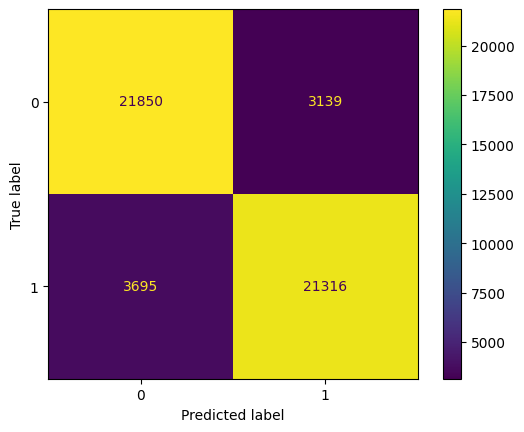

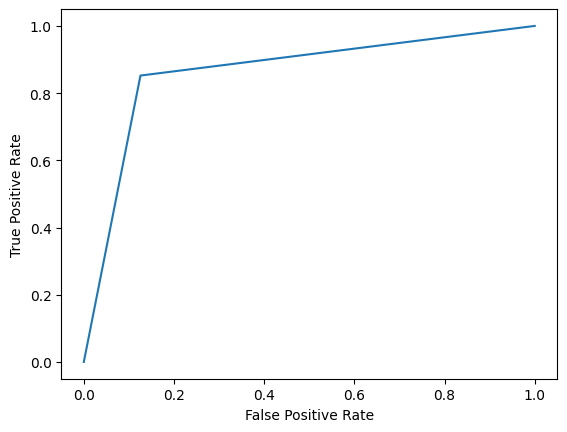

Runtime for training: 4142.62 sec
Accuracy:  85.898
Precision:  86.85397867104184
Recall:  84.62891171416011
F1-Score:  85.72700957470497


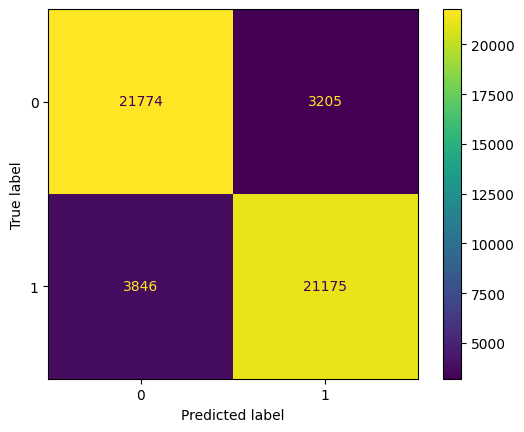

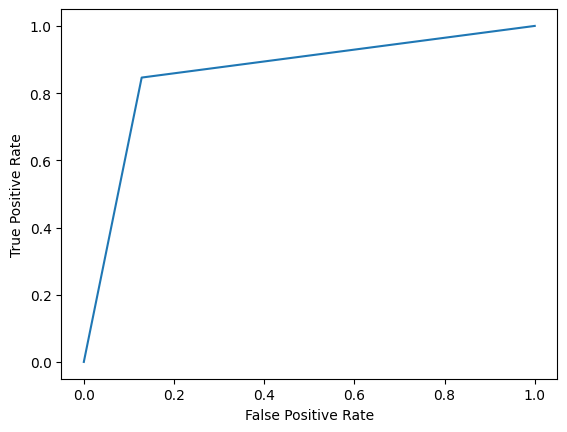

In [ ]:
# Run the previous function on stemmed columns
for col in tqdm(list(data_stemm.columns)[1:]):
    automatisation_tfidf_with_Random_Forest(data_stemm, col)

## VADER

In [ ]:
# Split the initial dataframe into two dataframes: one with lemmatised columns and one with stemmed columns
data_lemm = data[['label', 'nltk_gensim_token_keras', 'nltk_nltk_token_keras', 'nltk_gensim_token_nltk', 'nltk_nltk_token_nltk']].copy()
data_stemm = data[['label', 'nltk_stemmer_gensim_token_keras', 'nltk_stemmer_nltk_token_keras', 'nltk_stemmer_gensim_token_nltk', 'nltk_stemmer_nltk_token_nltk']].copy()

In [ ]:
def automatisation_VADER(data, column_name):
    
    # Display the name of the columns we are working on
    print("Column: ", column_name)
    
    # Change column type with ast.literal_eval()
    data[column_name] = data[column_name].apply(ast.literal_eval)
    
    # Join tokens from that specific column
    data['join_text'] = data[column_name].apply(lambda x: ' '.join(x))

    X = data['join_text']
    y = data['label'].astype(int).values.tolist()

    # Create train and test samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
    
    # Initialise VADER model
    sid_obj = SentimentIntensityAnalyzer()

    # Make predictions
    predictions = []

    for sentence in X_test:

        sentiment_dict = sid_obj.polarity_scores(sentence)

        if sentiment_dict['compound'] >= 0.05 :
            predictions.append(1)
        
        elif sentiment_dict['compound'] <= - 0.05 :
            predictions.append(0)
        
        else:
            predictions.append(None)
    
    # Compare only positive or negative reviews
    preds = []
    y_test_true = []
    
    for i in range(len(predictions)):
        elmt = predictions[i]
        y_elmt = y_test[i]
        
        if elmt != None:
            y_test_true.append(y_elmt)
            preds.append(elmt)
    
    # Display metrics scores
    print("Accuracy: ", accuracy_score(y_test_true,preds)*100)
    print("Precision: ", precision_score(y_test_true,preds)*100)
    print("Recall: ", recall_score(y_test_true,preds)*100)
    print("F1-Score: ", f1_score(y_test_true,preds)*100)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test_true, preds, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    fpr, tpr, _ = metrics.roc_curve(y_test_true, preds)

    # Create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

Column:  nltk_gensim_token_keras
Accuracy:  69.20023038630848
Precision:  63.131382265173706
Recall:  93.86957583652202
F1-Score:  75.49146383382711


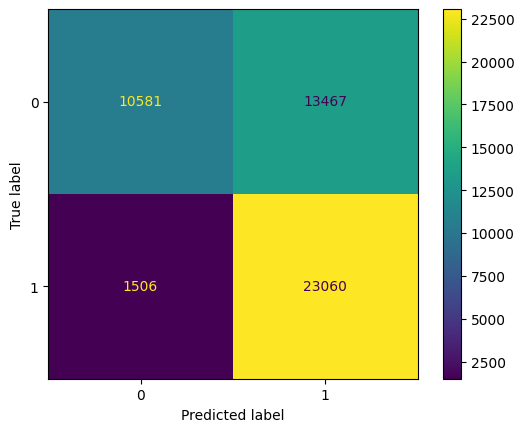

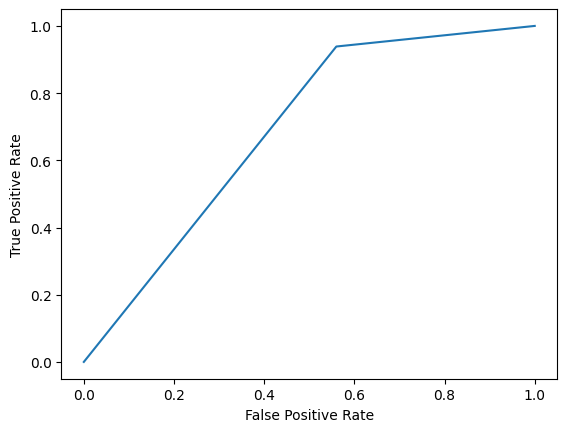

Column:  nltk_nltk_token_keras
Accuracy:  67.27373521681997
Precision:  61.475605550102145
Recall:  94.23342822285483
F1-Score:  74.40874717017485


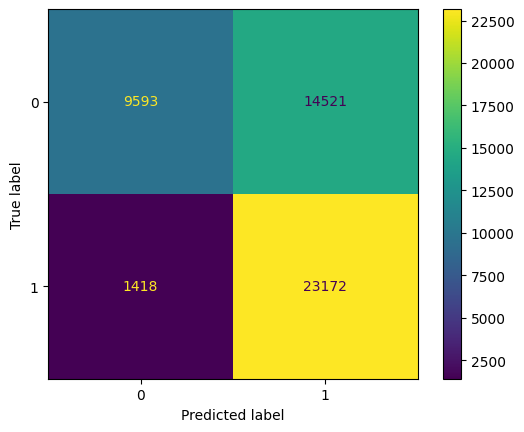

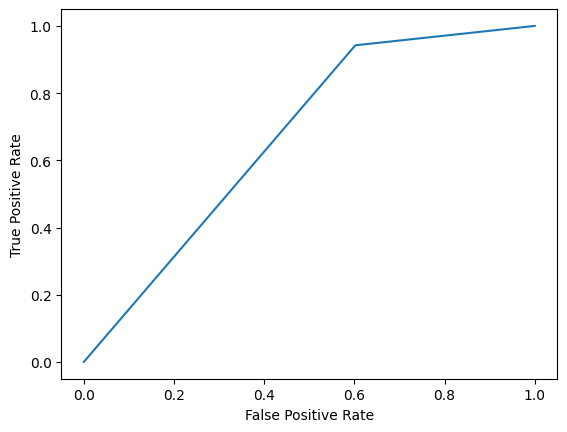

Column:  nltk_gensim_token_nltk
Accuracy:  69.19388364100347
Precision:  63.258032679021824
Recall:  93.64068016720101
F1-Score:  75.50763290082956


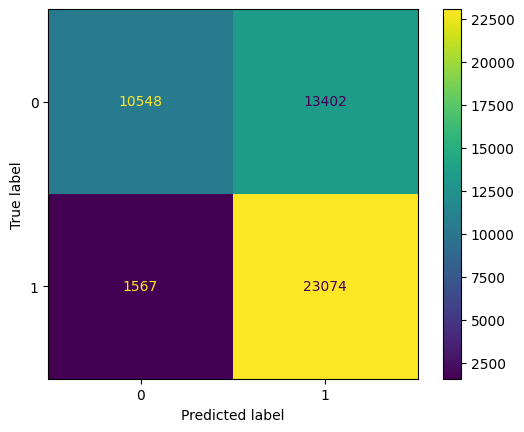

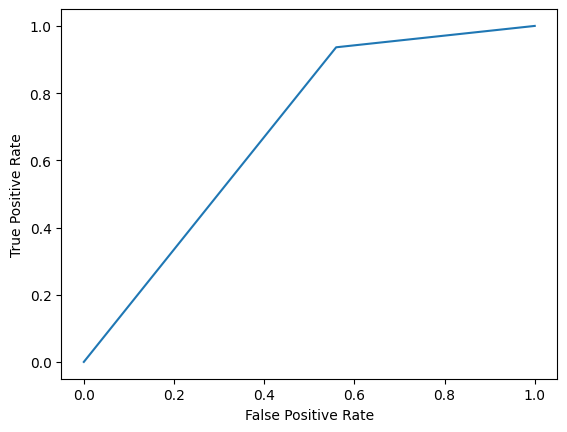

Column:  nltk_nltk_token_nltk
Accuracy:  67.37940507185469
Precision:  61.54173538330585
Recall:  94.08702724684831
F1-Score:  74.41142416055577


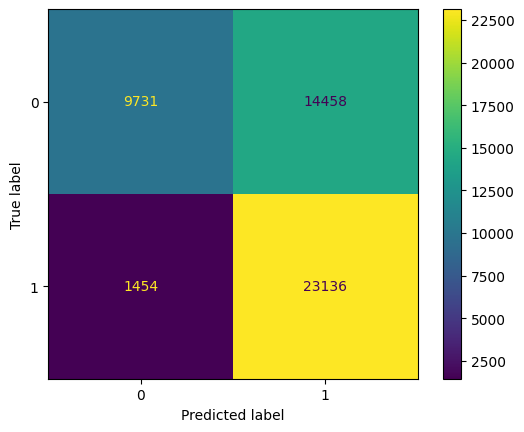

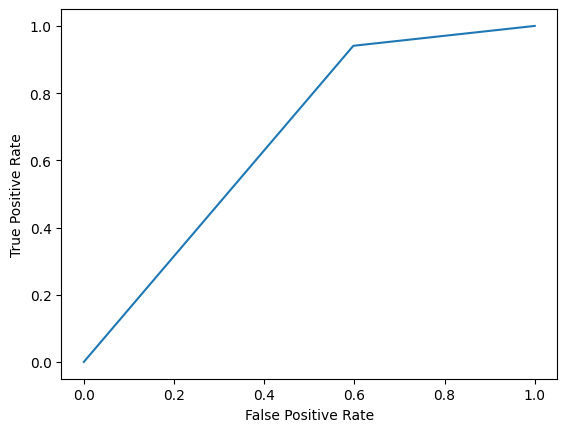

In [ ]:
# Run the previous function on lemmatised columns
for col in tqdm(list(data_lemm.columns)[1:]):
    automatisation_VADER(data_lemm, col)

  0%|          | 0/4 [00:00<?, ?it/s]

Column:  nltk_stemmer_gensim_token_keras
Accuracy:  67.08868693199625
Precision:  61.72274039529203
Recall:  91.88396214719616
F1-Score:  73.84221974992944


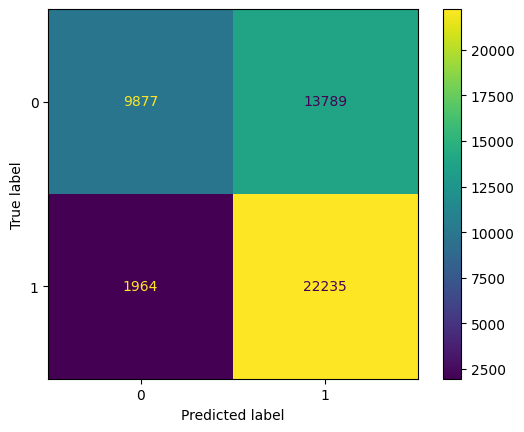

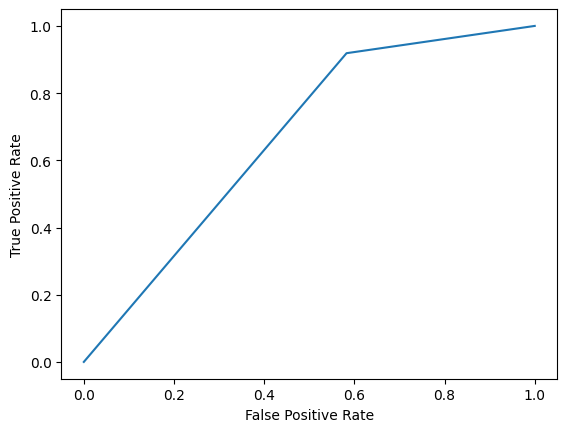

Column:  nltk_stemmer_nltk_token_keras
Accuracy:  65.3095243056279
Precision:  60.44907308757724
Recall:  92.65156154317208
F1-Score:  73.16365512016635


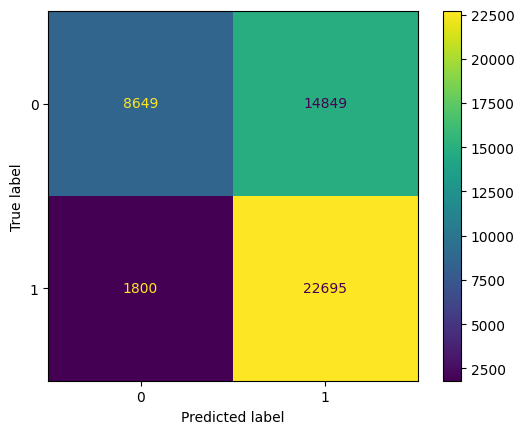

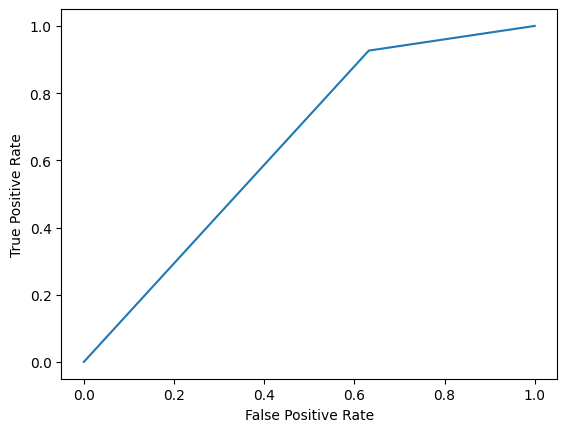

Column:  nltk_stemmer_gensim_token_nltk
Accuracy:  67.30941985083669
Precision:  62.10576041348265
Recall:  91.74500225770699
F1-Score:  74.07039172797774


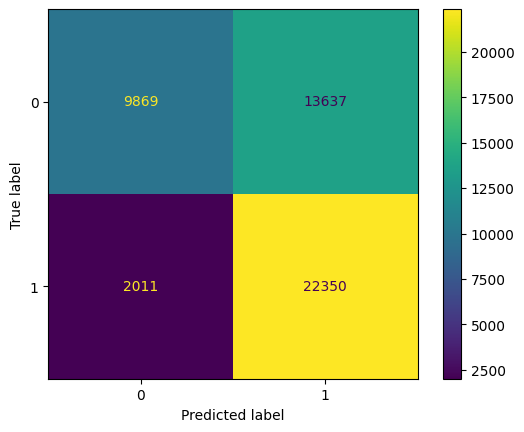

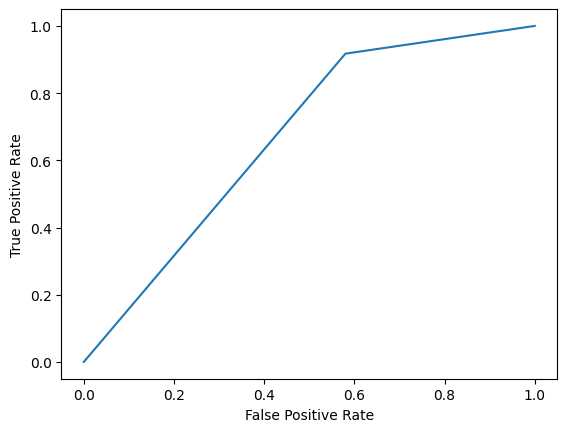

Column:  nltk_stemmer_nltk_token_nltk
Accuracy:  65.20355307773917
Precision:  60.38430956798304
Recall:  92.75332817652567
F1-Score:  73.14786573130208


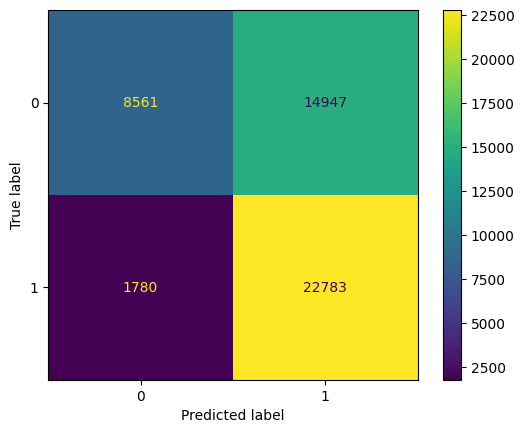

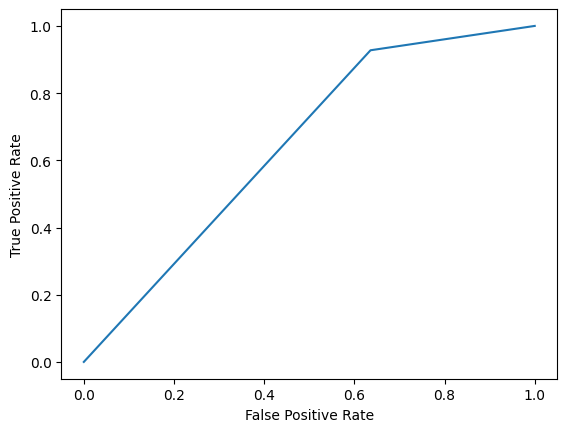

In [ ]:
# Run the previous function on stemmed columns
for col in tqdm(list(data_stemm.columns)[1:]):
    automatisation_VADER(data_stemm, col)